In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("Microsoft/microsoft-security-incident-prediction")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/microsoft-security-incident-prediction


In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import chi2_contingency
import pandas as pd

from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [4]:
pd.set_option('display.max_columns', None)

In [5]:
train_data_path = path + '/GUIDE_Train.csv'
test_data_path = path + '/GUIDE_Test.csv'

train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)

<ipython-input-5-53c71a8830dc>:5: DtypeWarning: Columns (10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  test_data = pd.read_csv(test_data_path)


columns 10, 11: action grouped, action granular: they have NaN values

# Initial Data Inspection

## Descriptive Statistics and Missing Data Analysis

In [6]:
train_data.head()

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Id,OrgId,IncidentId,AlertId,Timestamp,DetectorId,AlertTitle,Category,MitreTechniques,IncidentGrade,ActionGrouped,ActionGranular,EntityType,EvidenceRole,DeviceId,Sha256,IpAddress,Url,AccountSid,AccountUpn,AccountObjectId,AccountName,DeviceName,NetworkMessageId,EmailClusterId,RegistryKey,RegistryValueName,RegistryValueData,ApplicationId,ApplicationName,OAuthApplicationId,ThreatFamily,FileName,FolderPath,ResourceIdName,ResourceType,Roles,OSFamily,OSVersion,AntispamDirection,SuspicionLevel,LastVerdict,CountryCode,State,City
0,180388628218,0,612,123247,2024-06-04T06:05:15.000Z,7,6,InitialAccess,NaN,TruePositive,NaN,NaN,Ip,Related,98799,138268,27,160396,441377,673934,425863,453297,153085,529644,NaN,1631,635,860,2251,3421,881,NaN,289573,117668,3586,NaN,NaN,5,66,NaN,NaN,NaN,31,6,3
1,455266534868,88,326,210035,2024-06-14T03:01:25.000Z,58,43,Exfiltration,NaN,FalsePositive,NaN,NaN,User,Impacted,98799,138268,360606,160396,22406,23032,22795,24887,153085,529644,NaN,1631,635,860,2251,3421,881,NaN,289573,117668,3586,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630
2,1056561957389,809,58352,712507,2024-06-13T04:52:55.000Z,423,298,InitialAccess,T1189,FalsePositive,NaN,NaN,Url,Related,98799,138268,360606,68652,441377,673934,425863,453297,153085,529644,NaN,1631,635,860,2251,3421,881,NaN,289573,117668,3586,NaN,NaN,5,66,NaN,Suspicious,Suspicious,242,1445,10630
3,1279900258736,92,32992,774301,2024-06-10T16:39:36.000Z,2,2,CommandAndControl,NaN,BenignPositive,NaN,NaN,Url,Related,98799,138268,360606,13,441377,673934,425863,453297,153085,529644,NaN,1631,635,860,2251,3421,881,NaN,289573,117668,3586,NaN,NaN,5,66,NaN,Suspicious,Suspicious,242,1445,10630
4,214748368522,148,4359,188041,2024-06-15T01:08:07.000Z,9,74,Execution,NaN,TruePositive,NaN,NaN,User,Impacted,98799,138268,360606,160396,449,592,440,479,153085,529644,NaN,1631,635,860,2251,3421,881,NaN,289573,117668,3586,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630


**Dataset Description**

- **Id**: Unique ID for each `OrgId-IncidentId` pair.
- **OrgId**: Organization identifier.
- **IncidentId**: Organizationally unique incident identifier.
- **AlertId**: Unique identifier for an alert.
- **Timestamp**: Time the alert was created.
- **DetectorId**: Unique ID for the alert generating detector.
- **AlertTitle**: Title of the alert.
- **Category**: Category of the alert.
- **MitreTechniques**: MITRE ATT&CK techniques involved in the alert.
- **IncidentGrade**: SOC grade assigned to the incident.
- **ActionGrouped**: SOC alert remediation action (high level).
- **ActionGranular**: SOC alert remediation action (fine-grain).
- **EntityType**: Type of entity involved in the alert.
- **EvidenceRole**: Role of the evidence in the investigation.
- **DeviceId**: Unique identifier for the device.
- **Sha256**: SHA-256 hash of the file.
- **IpAddress**: IP address involved.
- **Url**: URL involved.
- **AccountSid**: On-premises account identifier.
- **AccountUpn**: Email account identifier.
- **AccountObjectId**: Entra ID account identifier.
- **AccountName**: Name of the on-premises account.
- **DeviceName**: Name of the device.
- **NetworkMessageId**: Org-level identifier for email message.
- **EmailClusterId**: Unique identifier for the email cluster.
- **RegistryKey**: Registry key involved.
- **RegistryValueName**: Name of the registry value.
- **RegistryValueData**: Data of the registry value.
- **ApplicationId**: Unique identifier for the application.
- **ApplicationName**: Name of the application.
- **OAuthApplicationId**: OAuth application identifier.
- **ThreatFamily**: Malware family associated with a file.
- **FileName**: Name of the file.
- **FolderPath**: Path of the file folder.
- **ResourceIdName**: Name of the Azure resource.
- **ResourceType**: Type of Azure resource.
- **Roles**: Additional metadata on evidence role in the alert.
- **OSFamily**: Family of the operating system.
- **OSVersion**: Version of the operating system.
- **AntispamDirection**: Direction of the antispam filter.
- **SuspicionLevel**: Level of suspicion.
- **LastVerdict**: Final verdict of threat analysis.
- **CountryCode**: Country code where the evidence appears.
- **State**: State where the evidence appears.
- **City**: City where the evidence appears.

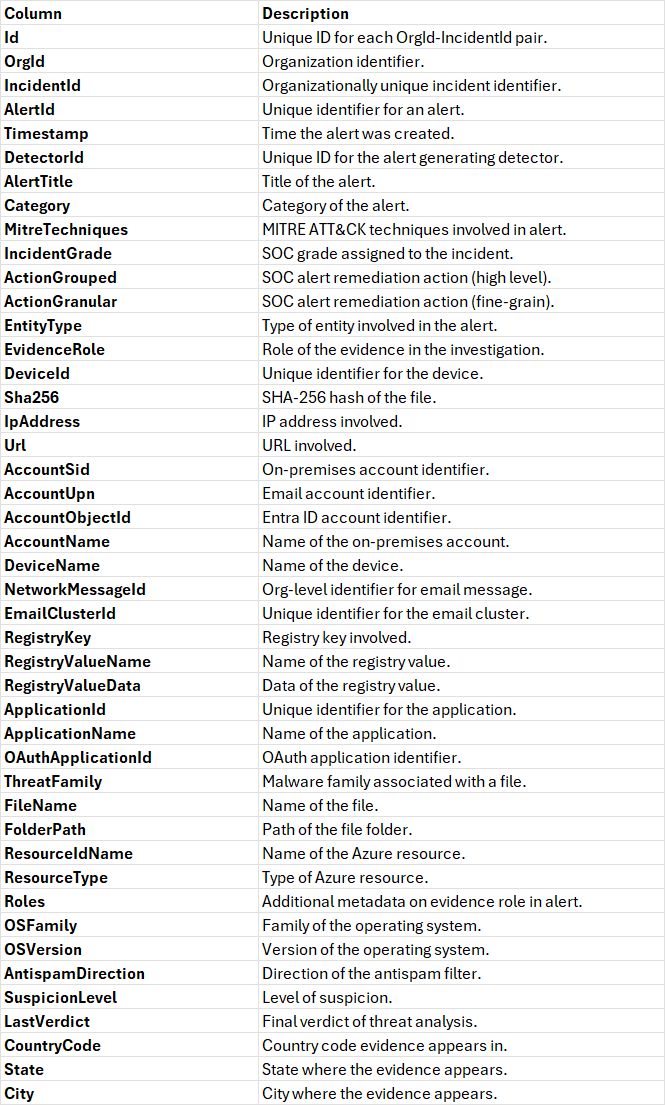
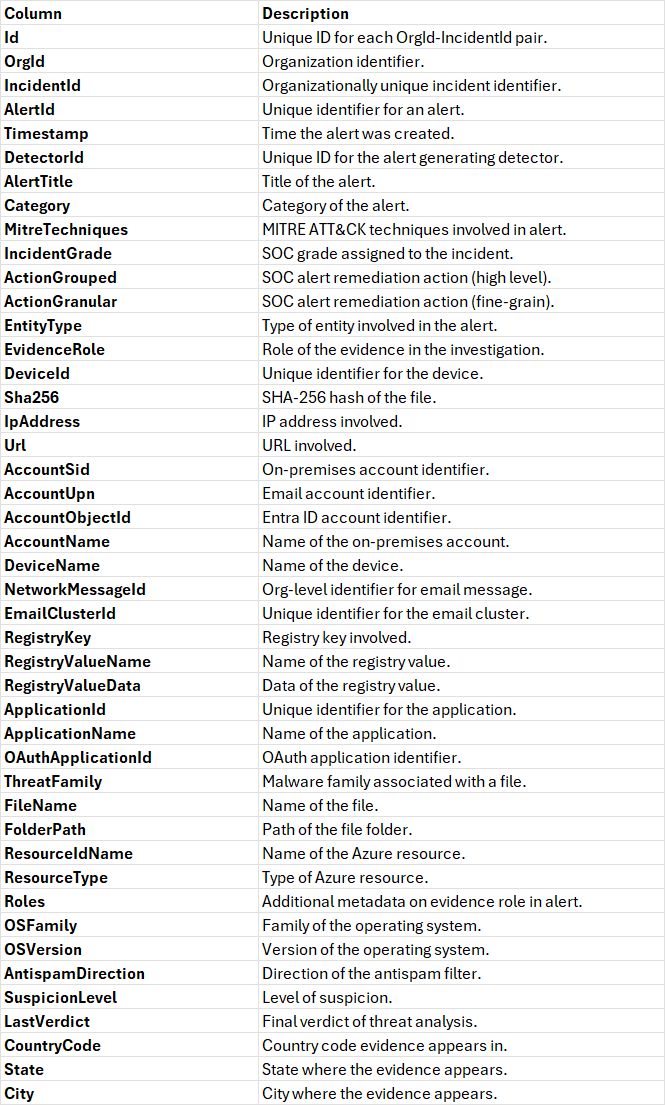
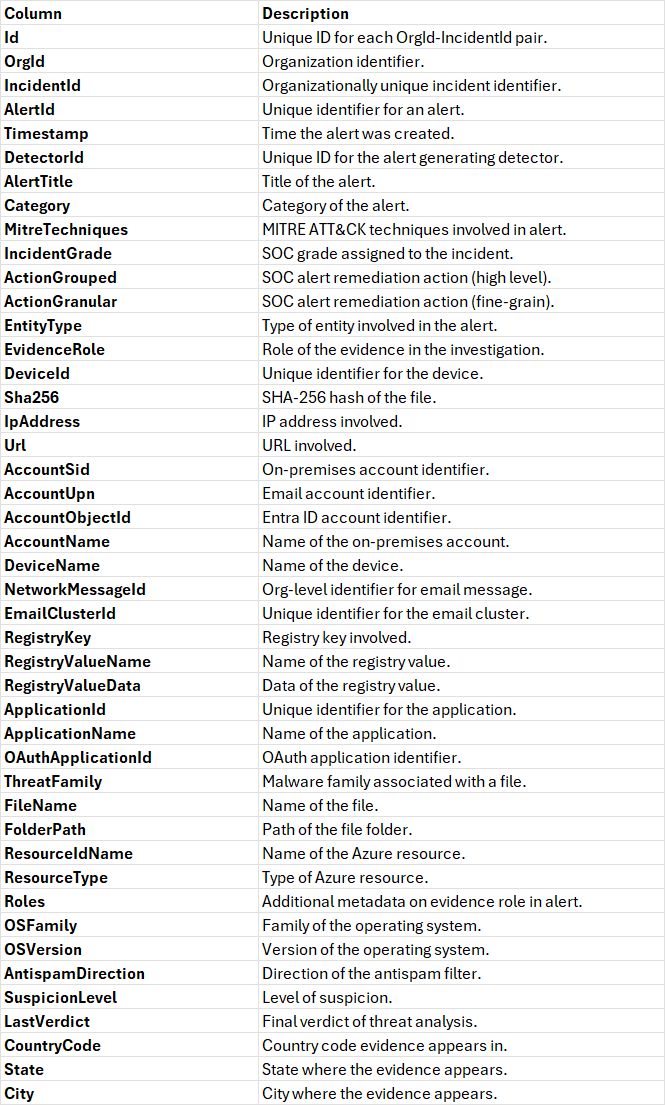
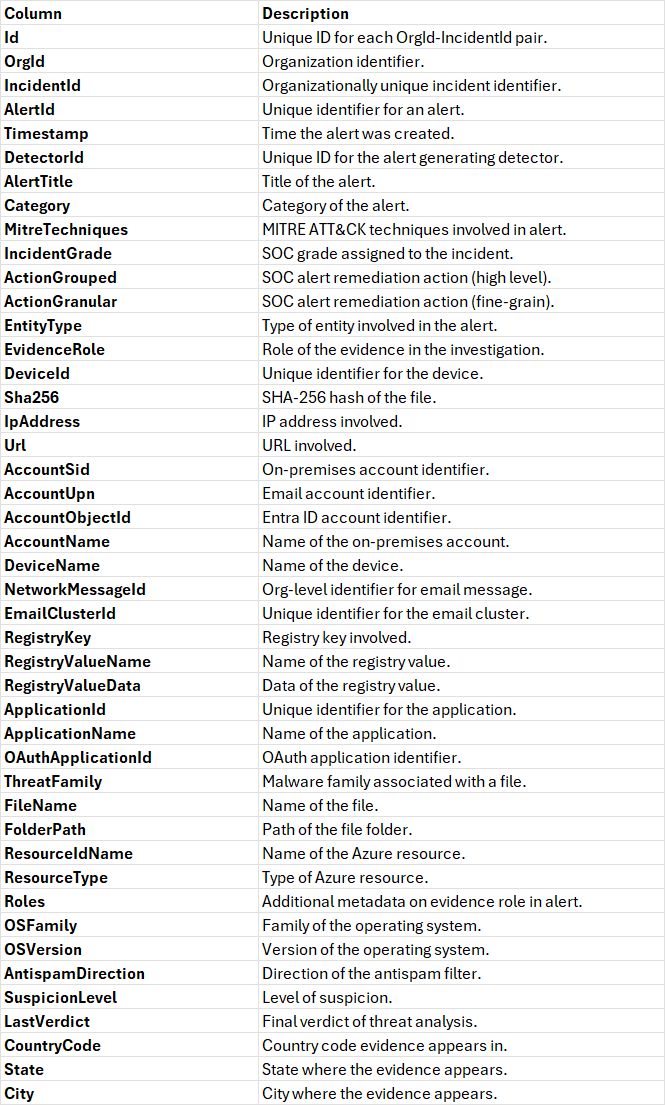

In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9516837 entries, 0 to 9516836
Data columns (total 45 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Id                  int64  
 1   OrgId               int64  
 2   IncidentId          int64  
 3   AlertId             int64  
 4   Timestamp           object 
 5   DetectorId          int64  
 6   AlertTitle          int64  
 7   Category            object 
 8   MitreTechniques     object 
 9   IncidentGrade       object 
 10  ActionGrouped       object 
 11  ActionGranular      object 
 12  EntityType          object 
 13  EvidenceRole        object 
 14  DeviceId            int64  
 15  Sha256              int64  
 16  IpAddress           int64  
 17  Url                 int64  
 18  AccountSid          int64  
 19  AccountUpn          int64  
 20  AccountObjectId     int64  
 21  AccountName         int64  
 22  DeviceName          int64  
 23  NetworkMessageId    int64  
 24  EmailClusterId      floa

### Things to note:
* Number of data entries in training data: 9.5mil
* number of features: 44
* label: IncidentGrade (index 9)
* Data types:
      float64 = 1; 
      int64 = 30; 
      object = 40

In [8]:
train_data.describe()

,Id,OrgId,IncidentId,AlertId,DetectorId,AlertTitle,DeviceId,Sha256,IpAddress,Url,AccountSid,AccountUpn,AccountObjectId,AccountName,DeviceName,NetworkMessageId,EmailClusterId,RegistryKey,RegistryValueName,RegistryValueData,ApplicationId,ApplicationName,OAuthApplicationId,FileName,FolderPath,ResourceIdName,OSFamily,OSVersion,CountryCode,State,City
count,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.681200e+04,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06
mean,8.425494e+11,1.815800e+02,7.066349e+04,4.065188e+05,1.106724e+02,2.947315e+03,9.566476e+04,1.287191e+05,2.857506e+05,1.503317e+05,3.524466e+05,4.643773e+05,3.409622e+05,3.569664e+05,1.432298e+05,4.800467e+05,3.242503e+09,1.628170e+03,6.347345e+02,8.595601e+02,2.200910e+03,3.342790e+03,8.807955e+02,2.622621e+05,1.076172e+05,3.583477e+03,4.898537e+00,6.465558e+01,2.236742e+02,1.351488e+03,9.936183e+03
std,4.962499e+11,3.867784e+02,1.208369e+05,4.592827e+05,4.351038e+02,1.146150e+04,1.635288e+04,3.399208e+04,1.412240e+05,3.750795e+04,1.664965e+05,2.902275e+05,1.599377e+05,1.744466e+05,3.607056e+04,1.417584e+05,1.034468e+09,6.675012e+01,1.258111e+01,1.886303e+01,3.315528e+02,5.103381e+02,1.291083e+01,8.152956e+04,3.220835e+04,9.020262e+01,7.035099e-01,9.314929e+00,6.279729e+01,3.509808e+02,2.606812e+03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.927080e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.123169e+11,1.000000e+01,5.040000e+02,2.324200e+04,2.000000e+00,2.000000e+00,9.879900e+04,1.382680e+05,3.606060e+05,1.603960e+05,4.413770e+05,9.258300e+04,4.258630e+05,4.532970e+05,1.530850e+05,5.296440e+05,2.762798e+09,1.631000e+03,6.350000e+02,8.600000e+02,2.251000e+03,3.421000e+03,8.810000e+02,2.895730e+05,1.176680e+05,3.586000e+03,5.000000e+00,6.600000e+01,2.420000e+02,1.445000e+03,1.063000e+04
50%,8.418136e+11,4.500000e+01,1.033600e+04,2.166520e+05,9.000000e+00,1.100000e+01,9.879900e+04,1.382680e+05,3.606060e+05,1.603960e+05,4.413770e+05,6.739340e+05,4.258630e+05,4.532970e+05,1.530850e+05,5.296440e+05,3.504264e+09,1.631000e+03,6.350000e+02,8.600000e+02,2.251000e+03,3.421000e+03,8.810000e+02,2.895730e+05,1.176680e+05,3.586000e+03,5.000000e+00,6.600000e+01,2.420000e+02,1.445000e+03,1.063000e+04
75%,1.271310e+12,1.710000e+02,8.432900e+04,6.715770e+05,4.500000e+01,1.800000e+02,9.879900e+04,1.382680e+05,3.606060e+05,1.603960e+05,4.413770e+05,6.739340e+05,4.258630e+05,4.532970e+05,1.530850e+05,5.296440e+05,4.107006e+09,1.631000e+03,6.350000e+02,8.600000e+02,2.251000e+03,3.421000e+03,8.810000e+02,2.895730e+05,1.176680e+05,3.586000e+03,5.000000e+00,6.600000e+01,2.420000e+02,1.445000e+03,1.063000e+04
max,1.709397e+12,6.147000e+03,5.997060e+05,1.721456e+06,9.522000e+03,1.131740e+05,9.879900e+04,1.382680e+05,3.606060e+05,1.603960e+05,4.413770e+05,6.739340e+05,4.258630e+05,4.532970e+05,1.530850e+05,5.296440e+05,4.294967e+09,1.631000e+03,6.350000e+02,8.600000e+02,2.251000e+03,3.421000e+03,8.810000e+02,2.895730e+05,1.176680e+05,3.586000e+03,5.000000e+00,6.600000e+01,2.420000e+02,1.445000e+03,1.063000e+04


**General Insights**
- **High counts for most columns**: Nearly all columns have a count close to **9.52 million**, indicating minimal missing values for those columns.
- **Notable exception**: `EmailClusterId` and `RegistryKey` have significantly fewer observations (~96,800 and ~324,000), suggesting high missingness and reduced usability.

<br>

**Numerical Insights**

**Central Tendency and Spread**
- **`Id`, `OrgId`, and `IncidentId`**:
  - These identifiers span a wide range, indicating a diverse set of records.
  - `IncidentId` has a **mean of 182** but a **max of 615,000**, reflecting variability in incident tracking.

- **`DetectorId` and `AlertId`**:
  - Large ranges indicate diverse and numerous alerts.
  - Detector usage (`DetectorId`) varies significantly, pointing to a wide range of monitoring tools or systems.

<br>

**Missing Values**
- Columns with low counts (`EmailClusterId`, `RegistryKey`, `RegistryValueName`, etc) indicate potential data quality issues.
- These columns may require **imputation strategies** or **removal**, depending on their relevance to the analysis.


In [9]:
# checking for missing vals in each column
missing_values = train_data.isnull().sum()
missing_percentage = (missing_values / len(train_data)) * 100

# creating df to get missing value details for all columns
missing_data = pd.DataFrame({'Column': missing_values.index, 
                             'Missing Values': missing_values.values, 
                             'Missing Percentage': missing_percentage.values})
missing_data = missing_data[missing_data['Missing Percentage'] > 0].sort_values('Missing Percentage', ascending=False)
print(missing_data)


               Column  Missing Values  Missing Percentage
35       ResourceType         9509762           99.925658
10      ActionGrouped         9460773           99.410897
11     ActionGranular         9460773           99.410897
31       ThreatFamily         9441956           99.213173
24     EmailClusterId         9420025           98.982729
39  AntispamDirection         9339535           98.136965
36              Roles         9298686           97.707736
40     SuspicionLevel         8072708           84.825536
41        LastVerdict         7282572           76.523030
8     MitreTechniques         5468386           57.460120
9       IncidentGrade           51340            0.539465


**A large number of missing values are present.**

**columns having 95% or more missing data can be dropped for now**


In [10]:
missing_data_columns = list(missing_data.drop([9])['Column'])
filtered_columns = [col for col in train_data.columns if col not in missing_data_columns]
print('columns to keep:')
print(filtered_columns)
print('\ncolumns to drop:')
print(missing_data_columns)

columns to keep:
['Id', 'OrgId', 'IncidentId', 'AlertId', 'Timestamp', 'DetectorId', 'AlertTitle', 'Category', 'IncidentGrade', 'EntityType', 'EvidenceRole', 'DeviceId', 'Sha256', 'IpAddress', 'Url', 'AccountSid', 'AccountUpn', 'AccountObjectId', 'AccountName', 'DeviceName', 'NetworkMessageId', 'RegistryKey', 'RegistryValueName', 'RegistryValueData', 'ApplicationId', 'ApplicationName', 'OAuthApplicationId', 'FileName', 'FolderPath', 'ResourceIdName', 'OSFamily', 'OSVersion', 'CountryCode', 'State', 'City']

columns to drop:
['ResourceType', 'ActionGrouped', 'ActionGranular', 'ThreatFamily', 'EmailClusterId', 'AntispamDirection', 'Roles', 'SuspicionLevel', 'LastVerdict', 'MitreTechniques']


## Inspecting Dataset Features

Before dropping some of the columns with missing values, lets inspect them to see if we can find any useful information.

**1. Mitre Attack techniques and Tactics**

In [11]:
train_data['MitreTechniques'].value_counts()

MitreTechniques
T1078;T1078.004                                        1354904
T1566.002                                               814308
T1566                                                   659591
T1133                                                   145579
T1566.001                                               136892
                                                        ...   
T1084                                                        1
T1055;T1055.003;T1055.012;T1059;T1059.001;T1106              1
T1003.001;T1055;T1055.003;T1055.012;T1106;T1550.002          1
T1055;T1055.002;T1055.003;T1055.012;T1078;T1106              1
T1078;T1078.001                                              1
Name: count, Length: 1193, dtype: int64

**MitreTechniques:**
* Techniques: 203
* Sub-techniques: 453


Most common Mitre Technique:

* T1078: Valid Accounts
  * Adversaries may obtain and abuse credentials of existing accounts as a means of gaining Initial Access, Persistence, Privilege Escalation, or Defense Evasion.
  * Valid Accounts refer to attackers leveraging legitimate credentials (usernames and passwords) to gain unauthorized access to a target system or network
  * This technique falls under multiple tactics in the MITRE ATT&CK framework, including Initial Access, Persistence, Privilege Escalation, and Defense Evasion, as it serves diverse purposes depending on the stage of the attack.
  * 004: Cloud Accounts

<br>

* T1566: Phishing
  * Adversaries may send phishing messages to gain access to victim systems.
  * Phishing can be targeted, known as spearphishing. Spearphishing may also involve social engineering techniques, such as posing as a trusted source.
  * 002: Spearphishing Link - Adversaries may send spearphishing emails with a malicious link in an attempt to gain access to victim systems
  * 001: Spearphishing Attachment - Spearphishing attachment is different from other forms of spearphishing in that it employs the use of malware attached to an email.

<br>

* T1133: External Remote Services
  * External Remote Services refers to the use of external or remote systems and services to gain unauthorized access to a target network or system. 

In [12]:
train_data['Category'].value_counts()

Category
InitialAccess          4293041
Exfiltration           1577965
SuspiciousActivity     1003933
CommandAndControl       826691
Impact                  750885
CredentialAccess        300518
Execution               267594
Malware                 144081
Discovery               129342
Persistence              72682
DefenseEvasion           46662
LateralMovement          41754
Ransomware               18974
UnwantedSoftware         18211
Collection               14753
PrivilegeEscalation       4671
Exploit                   4648
CredentialStealing         388
WebExploit                  38
Weaponization                6
Name: count, dtype: int64

In [13]:
technique_counts = train_data.groupby(['Category', 'MitreTechniques']).size().reset_index(name='Count')
sorted_by_techniques = technique_counts.sort_values(by='Count', ascending=False)

In [14]:
# Display the results
sorted_by_techniques.head(10)

,Category,MitreTechniques,Count
819,InitialAccess,T1078;T1078.004,1351196
839,InitialAccess,T1566.002,814045
836,InitialAccess,T1566,658907
822,InitialAccess,T1133,145579
837,InitialAccess,T1566.001,136887
187,CredentialAccess,T1110;T1110.003;T1110.001,88661
575,Discovery,T1087;T1087.002,54564
1102,Persistence,T1078;T1098,39880
736,Execution,T1559;T1106;T1059.005,37869
177,CredentialAccess,T1110,37156


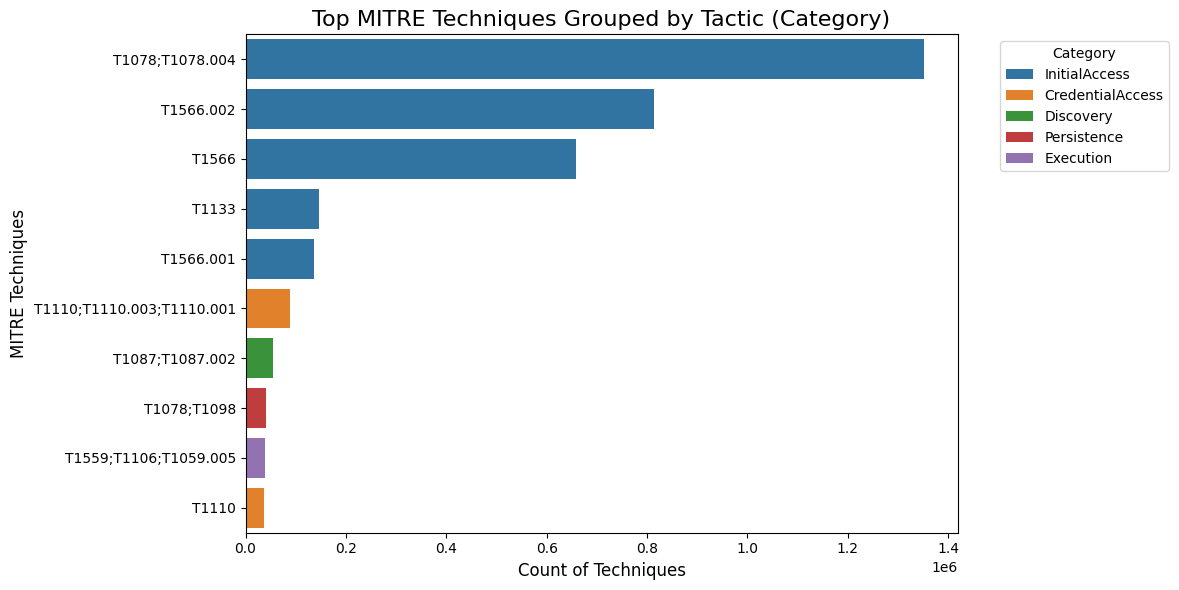

In [15]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Count', y='MitreTechniques', data=sorted_by_techniques.head(10), hue='Category', dodge=False)

# Add labels and title
plt.title('Top MITRE Techniques Grouped by Tactic (Category)', fontsize=16)
plt.xlabel('Count of Techniques', fontsize=12)
plt.ylabel('MITRE Techniques', fontsize=12)
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show plot
plt.tight_layout()
plt.show()

**Interpretation**

* **InitialAccess Tactics:**
    * **T1078 (Valid Accounts)** is the most frequently observed technique in the InitialAccess category, with a massive count of 1,351,196. This suggests that adversaries are most commonly using legitimate credentials to gain access to systems.
    * **T1566 (Phishing)** and its sub-techniques (**T1566.002** and **T1566.001**) are also significant, indicating that phishing attacks are commonly used to gain initial access.
    * Other techniques like **T1133 (External Remote Services)**, with a much lower count (145,579), show a lesser but still notable presence in initial access strategies.

<br>

* **CredentialAccess Tactics:**
    * **T1110 (Brute Force)** appears with multiple sub-techniques (T1110.003;T1110.001), showing that brute force is a frequent method to attempt unauthorized access via credential guessing. This technique appears 88,661 times, indicating it is a common method for credential access attempts.

<br>

* **Discovery Tactics:**

    * **T1087 (Account Discovery)** with the sub-technique **T1087.002 (Account Discovery via Service Accounts)** appears 54,564 times. This indicates a significant focus on discovering account-related information during attacks.

<br>

* **Persistence Tactics:**

    * **T1078 (Valid Accounts)** and **T1098 (Account Manipulation)** are observed 39,880 times, suggesting that adversaries rely on valid accounts to maintain access to compromised systems.


<br>

* **Execution Tactics:**

    * **T1559, T1106, T1059.005**: These techniques related to executing attacks (likely through malicious scripts or payloads) are seen 37,869 times.

In [16]:
train_data['ActionGrouped'].value_counts()

ActionGrouped
ContainAccount           53760
IsolateDevice             2237
Stop Virtual Machines       67
Name: count, dtype: int64

In [17]:
top_techniques = sorted_by_techniques['MitreTechniques'].head(5)

filtered_data = train_data[train_data['MitreTechniques'].isin(top_techniques)]
action_grouped_counts = filtered_data.groupby(['MitreTechniques', 'ActionGrouped']).size().reset_index(name='Count')

# Sort the results by the count of each action (optional)
action_grouped_counts_sorted = action_grouped_counts.sort_values(by='Count', ascending=False)

# Print the grouped action counts
print(action_grouped_counts_sorted)


   MitreTechniques   ActionGrouped  Count
1            T1566  ContainAccount   3457
0  T1078;T1078.004  ContainAccount   1359
4        T1566.002  ContainAccount    905
5        T1566.002   IsolateDevice     16
3        T1566.001   IsolateDevice      5
2            T1566   IsolateDevice      1


# Data Cleaning

In [18]:
# converting timestamp column to proper format
train_data['Timestamp'] = pd.to_datetime(train_data['Timestamp'], errors='coerce')

**Timestamp will be converted to the following format: YYYY-MM-DD HH:MM:SS±HH:MM**

* date in ISO 8601 format (YYYY-MM-DD)

* time in HH:MM:SS format (24-hour clock)

* timezone offset from Coordinated Universal Time (UTC)

In [19]:
# dropping columns having missing data
train_data.drop(missing_data_columns, axis=1, inplace=True)

**Number of columns after dropping the  missing ones:** 35 (including label - IncidentGrade)

In [20]:
train_data.head()

,Id,OrgId,IncidentId,AlertId,Timestamp,DetectorId,AlertTitle,Category,IncidentGrade,EntityType,EvidenceRole,DeviceId,Sha256,IpAddress,Url,AccountSid,AccountUpn,AccountObjectId,AccountName,DeviceName,NetworkMessageId,RegistryKey,RegistryValueName,RegistryValueData,ApplicationId,ApplicationName,OAuthApplicationId,FileName,FolderPath,ResourceIdName,OSFamily,OSVersion,CountryCode,State,City
0,180388628218,0,612,123247,2024-06-04 06:05:15+00:00,7,6,InitialAccess,TruePositive,Ip,Related,98799,138268,27,160396,441377,673934,425863,453297,153085,529644,1631,635,860,2251,3421,881,289573,117668,3586,5,66,31,6,3
1,455266534868,88,326,210035,2024-06-14 03:01:25+00:00,58,43,Exfiltration,FalsePositive,User,Impacted,98799,138268,360606,160396,22406,23032,22795,24887,153085,529644,1631,635,860,2251,3421,881,289573,117668,3586,5,66,242,1445,10630
2,1056561957389,809,58352,712507,2024-06-13 04:52:55+00:00,423,298,InitialAccess,FalsePositive,Url,Related,98799,138268,360606,68652,441377,673934,425863,453297,153085,529644,1631,635,860,2251,3421,881,289573,117668,3586,5,66,242,1445,10630
3,1279900258736,92,32992,774301,2024-06-10 16:39:36+00:00,2,2,CommandAndControl,BenignPositive,Url,Related,98799,138268,360606,13,441377,673934,425863,453297,153085,529644,1631,635,860,2251,3421,881,289573,117668,3586,5,66,242,1445,10630
4,214748368522,148,4359,188041,2024-06-15 01:08:07+00:00,9,74,Execution,TruePositive,User,Impacted,98799,138268,360606,160396,449,592,440,479,153085,529644,1631,635,860,2251,3421,881,289573,117668,3586,5,66,242,1445,10630


In [21]:
# checking missing rows
train_data.isnull().sum()

Id                        0
OrgId                     0
IncidentId                0
AlertId                   0
Timestamp                 0
DetectorId                0
AlertTitle                0
Category                  0
IncidentGrade         51340
EntityType                0
EvidenceRole              0
DeviceId                  0
Sha256                    0
IpAddress                 0
Url                       0
AccountSid                0
AccountUpn                0
AccountObjectId           0
AccountName               0
DeviceName                0
NetworkMessageId          0
RegistryKey               0
RegistryValueName         0
RegistryValueData         0
ApplicationId             0
ApplicationName           0
OAuthApplicationId        0
FileName                  0
FolderPath                0
ResourceIdName            0
OSFamily                  0
OSVersion                 0
CountryCode               0
State                     0
City                      0
dtype: int64

**Only Incident Grade has null values which is approx 0.5% of the dataset. the rows can be dropped without causing much data loss**

In [22]:
# dropping the rows having null values
train_data = train_data.dropna()

In [23]:
# checking missing rows
print(train_data.isnull().sum())
print('\nnew size of dataset: ')
print(train_data.shape)

Id                    0
OrgId                 0
IncidentId            0
AlertId               0
Timestamp             0
DetectorId            0
AlertTitle            0
Category              0
IncidentGrade         0
EntityType            0
EvidenceRole          0
DeviceId              0
Sha256                0
IpAddress             0
Url                   0
AccountSid            0
AccountUpn            0
AccountObjectId       0
AccountName           0
DeviceName            0
NetworkMessageId      0
RegistryKey           0
RegistryValueName     0
RegistryValueData     0
ApplicationId         0
ApplicationName       0
OAuthApplicationId    0
FileName              0
FolderPath            0
ResourceIdName        0
OSFamily              0
OSVersion             0
CountryCode           0
State                 0
City                  0
dtype: int64

new size of dataset: 
(9465497, 35)


**Now there are no null entries in the dataset and the new shape of the dataset is (9465497, 35)**

In [24]:
# checking for duplicates
train_data[train_data.duplicated(keep=False)].index

Index([     20,      21,      22,      34,      39,      43,      50,      69,
            71,      84,
       ...
       9516696, 9516703, 9516713, 9516761, 9516793, 9516796, 9516803, 9516812,
       9516813, 9516823],
      dtype='int64', length=930238)

**approx 9.3L duplicate entries are present in the dataset.**

**These entries need to be dropped otherwise it may introduce bias in the model which may also lead to model overfitting**

In [25]:
# checking some duplicated rows
row_data = train_data.loc[20]
train_data[train_data.eq(row_data).all(axis=1)]

,Id,OrgId,IncidentId,AlertId,Timestamp,DetectorId,AlertTitle,Category,IncidentGrade,EntityType,EvidenceRole,DeviceId,Sha256,IpAddress,Url,AccountSid,AccountUpn,AccountObjectId,AccountName,DeviceName,NetworkMessageId,RegistryKey,RegistryValueName,RegistryValueData,ApplicationId,ApplicationName,OAuthApplicationId,FileName,FolderPath,ResourceIdName,OSFamily,OSVersion,CountryCode,State,City
20,1365799604919,428,54837,239519,2024-06-09 04:11:51+00:00,1,1,InitialAccess,BenignPositive,Url,Related,98799,138268,360606,1557,441377,673934,425863,453297,153085,529644,1631,635,860,2251,3421,881,289573,117668,3586,5,66,242,1445,10630
5917725,1365799604919,428,54837,239519,2024-06-09 04:11:51+00:00,1,1,InitialAccess,BenignPositive,Url,Related,98799,138268,360606,1557,441377,673934,425863,453297,153085,529644,1631,635,860,2251,3421,881,289573,117668,3586,5,66,242,1445,10630


In [26]:
# total number of duplicate entries
print('Number of duplicate entries:', train_data.duplicated(keep=False).sum())

Number of duplicate entries: 930238


In [27]:
# dropping duplicated rows
train_data.drop_duplicates(inplace=True)

In [28]:
train_data.shape

(8922805, 35)

**New shape of our cleaned data:**

**8.9mil rows**

**35 columns (including label: IncidentGrade)**

In [29]:
# categorical features
categorical_columns = train_data.select_dtypes(include=['object']).columns
print('categorical columns\n', categorical_columns)

# numerical features
numerical_columns = train_data.select_dtypes(include=['int64', 'float64']).columns
print('numerical columns\n', numerical_columns)

categorical columns
 Index(['Category', 'IncidentGrade', 'EntityType', 'EvidenceRole'], dtype='object')
numerical columns
 Index(['Id', 'OrgId', 'IncidentId', 'AlertId', 'DetectorId', 'AlertTitle',
       'DeviceId', 'Sha256', 'IpAddress', 'Url', 'AccountSid', 'AccountUpn',
       'AccountObjectId', 'AccountName', 'DeviceName', 'NetworkMessageId',
       'RegistryKey', 'RegistryValueName', 'RegistryValueData',
       'ApplicationId', 'ApplicationName', 'OAuthApplicationId', 'FileName',
       'FolderPath', 'ResourceIdName', 'OSFamily', 'OSVersion', 'CountryCode',
       'State', 'City'],
      dtype='object')


# EDA

## Univariate analysis

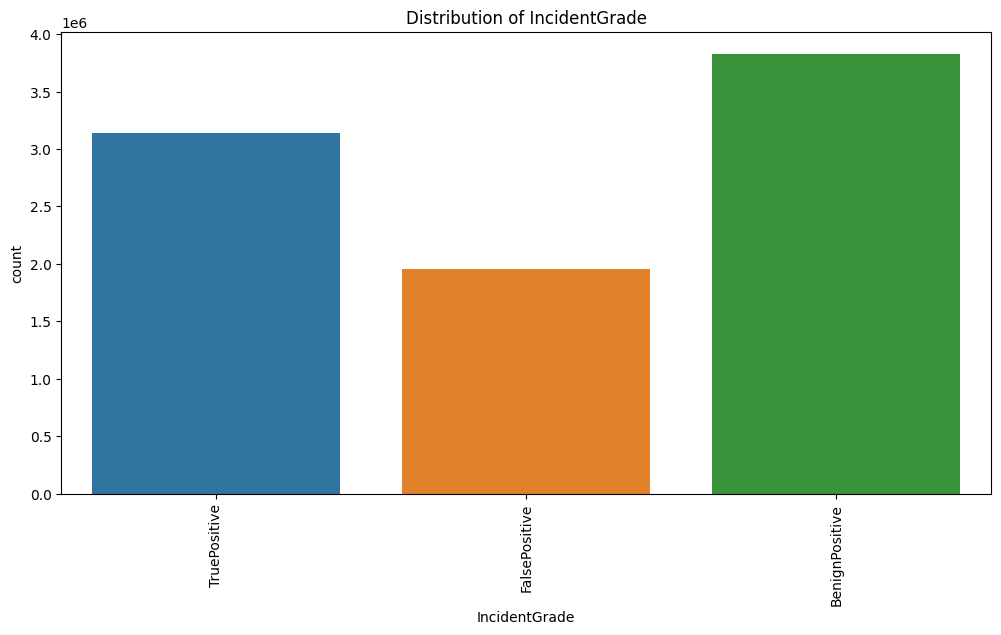

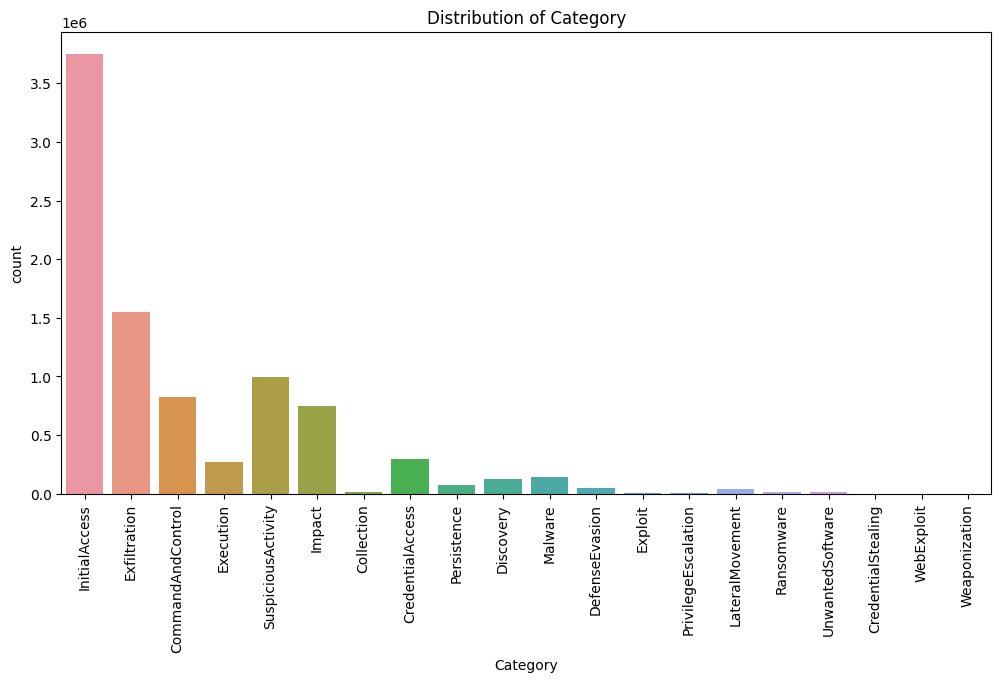

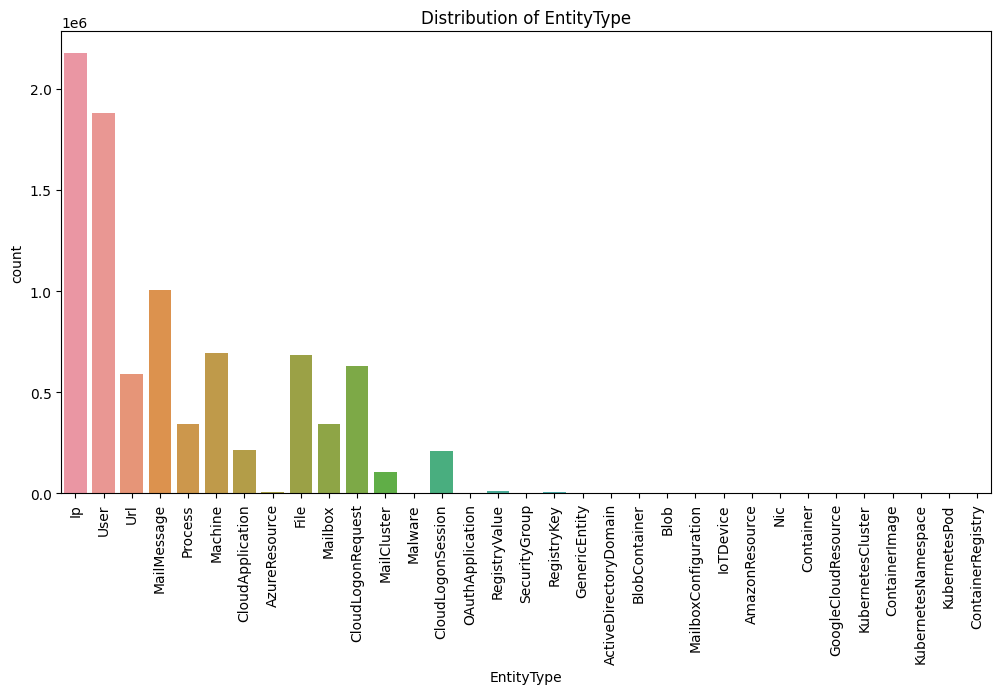

In [30]:
# Plots for frequency of categories
categorical_columns = ['IncidentGrade', 'Category', 'EntityType']
for column in categorical_columns:
    plt.figure(figsize=(12, 6))
    sns.countplot(data=train_data, x=column)
    plt.title(f'Distribution of {column}')
    plt.xticks(rotation=90)
    plt.show()

In [31]:
print('percentage distribution of IncidentGrade classes:')
train_data['IncidentGrade'].value_counts()/len(train_data)*100

percentage distribution of IncidentGrade classes:


IncidentGrade
BenignPositive    42.899066
TruePositive      35.192140
FalsePositive     21.908794
Name: count, dtype: float64

In [32]:
print('percentage distribution of Category classes: (unique vals: {})'.format(train_data['Category'].nunique()))
train_data['Category'].value_counts()/len(train_data)*100

percentage distribution of Category classes: (unique vals: 20)


Category
InitialAccess          42.049983
Exfiltration           17.379075
SuspiciousActivity     11.121144
CommandAndControl       9.252472
Impact                  8.414921
CredentialAccess        3.334960
Execution               2.989340
Malware                 1.578214
Discovery               1.433607
Persistence             0.811897
DefenseEvasion          0.518043
LateralMovement         0.449444
UnwantedSoftware        0.201786
Ransomware              0.194748
Collection              0.161900
PrivilegeEscalation     0.052282
Exploit                 0.051363
CredentialStealing      0.004326
WebExploit              0.000426
Weaponization           0.000067
Name: count, dtype: float64

In [33]:
print('percentage distribution of EntityType classes: (unique vals: {})'.format(train_data['EntityType'].nunique()))
train_data['EntityType'].value_counts()/len(train_data)*100

percentage distribution of EntityType classes: (unique vals: 33)


EntityType
Ip                       24.375720
User                     21.063455
MailMessage              11.261268
Machine                   7.805528
File                      7.644222
CloudLogonRequest         7.088612
Url                       6.604481
Mailbox                   3.872034
Process                   3.867270
CloudApplication          2.429696
CloudLogonSession         2.359751
MailCluster               1.196754
RegistryValue             0.125622
AzureResource             0.090779
RegistryKey               0.081555
GenericEntity             0.048124
OAuthApplication          0.029083
Malware                   0.028915
SecurityGroup             0.016889
BlobContainer             0.003429
Blob                      0.002948
MailboxConfiguration      0.002533
Nic                       0.000549
IoTDevice                 0.000347
ActiveDirectoryDomain     0.000123
GoogleCloudResource       0.000112
AmazonResource            0.000067
Container                 0.000022
Kubernete

**Plot 1: Distribution of `IncidentGrade`**
* Indicent Grade (label) has 3 categories - TruPositive, FalsePositive and BenignPositive
* Class imbalance is visible - BenignPositive class has almost 2x more entries than FalsePositive class
* this can lead to the model being biased towards the majority class, making it ineffective at detecting the minority class.

**Plot 2: Distribution of `Category`**
* These are categories of the alert
* most common alert category were **InitialAccess (42% of the incidents)**, **Exfiltration (17%)** and **Suspicious Activity (11%)**

**Plot 3: Distribution of `EntityType`**
* There are 33 different types of entites involved in the alerts
* Most common entity type is Ip (24% of the alerts), User (21%) and MailMessage (11%) while the others were less than 10%


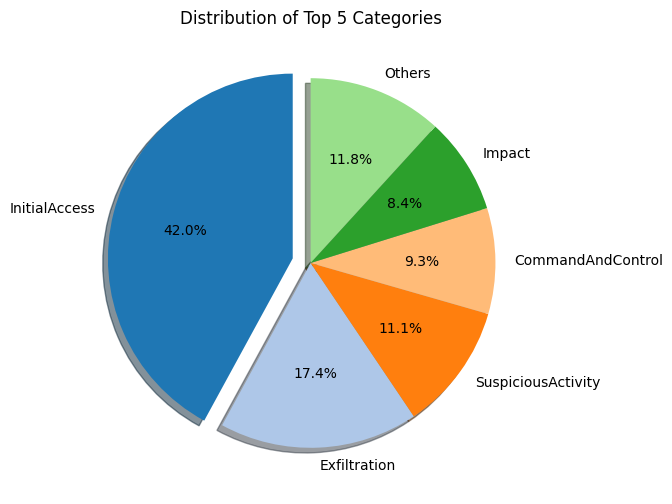

In [34]:
# pie chart for category col
other_categories = train_data['Category'].value_counts().iloc[5:].sum()
top_5_categories = train_data['Category'].value_counts().nlargest(5)
top_5_categories['Others'] = other_categories

plt.figure(figsize=(6, 6))
colors = plt.cm.tab20.colors
explode = [0.1 if i == top_5_categories.idxmax() else 0 for i in top_5_categories.index]

plt.pie(
    top_5_categories,
    labels=top_5_categories.index,
    autopct='%1.1f%%',  # format to display percentages
    startangle=90,
    colors=colors[:len(top_5_categories)],  # limiting colors to the number of categories
    explode=explode,  # highlighting the largest category
    shadow=True
)

plt.title('Distribution of Top 5 Categories')
plt.show()


**Pie Chart Interpretation**
* Out of 20 classes of `Category` (category of the alerts), InitialAccess has the highest occurance with 42%
* the others with high frequencies were: Exfiltration, SuspiciousActivity, CommandAndControl and Impact
* All other categories of the alerts make up to 11.8%

In [35]:
# checking unique vals in columns
cols = ['Id', 'OrgId', 'IncidentId', 'AlertId', 'DetectorId', 'AlertTitle',
       'DeviceId', 'Sha256', 'IpAddress', 'Url', 'AccountSid', 'AccountUpn',
       'AccountObjectId', 'AccountName', 'DeviceName', 'NetworkMessageId', 
         'RegistryKey', 'RegistryValueName',
       'RegistryValueData', 'ApplicationId', 'ApplicationName',
       'OAuthApplicationId', 'FileName', 'FolderPath', 'ResourceIdName',
       'OSFamily', 'OSVersion', 'CountryCode', 'State', 'City']
for col in cols:
    print(f'{col}: {train_data[col].nunique()}')

Id: 707108
OrgId: 5340
IncidentId: 448901
AlertId: 1248789
DetectorId: 7813
AlertTitle: 79952
DeviceId: 75557
Sha256: 106416
IpAddress: 285957
Url: 123252
AccountSid: 353113
AccountUpn: 524760
AccountObjectId: 338252
AccountName: 363254
DeviceName: 114267
NetworkMessageId: 375196
RegistryKey: 1341
RegistryValueName: 525
RegistryValueData: 699
ApplicationId: 1728
ApplicationName: 2681
OAuthApplicationId: 703
FileName: 222085
FolderPath: 87832
ResourceIdName: 2283
OSFamily: 6
OSVersion: 58
CountryCode: 236
State: 1368
City: 9342


**Things to Note:**
* There are aprox **70.7k unique OrgId-IncidentId pairs**
* The dataset includes data from **5.3k unique organizations**, which implies that the incidents and alerts cover a wide range of industries or sectors
* The alerts are generated from **7.8k different detectors**. This suggests a large and varied set of detection tools or systems were used to identify security incidents
* The incidents span **6 different families of operating systems**, showing the diversity in environments where incidents are happening
* The data spans **236 countries**, demonstrating the global scale of the incidents being tracked


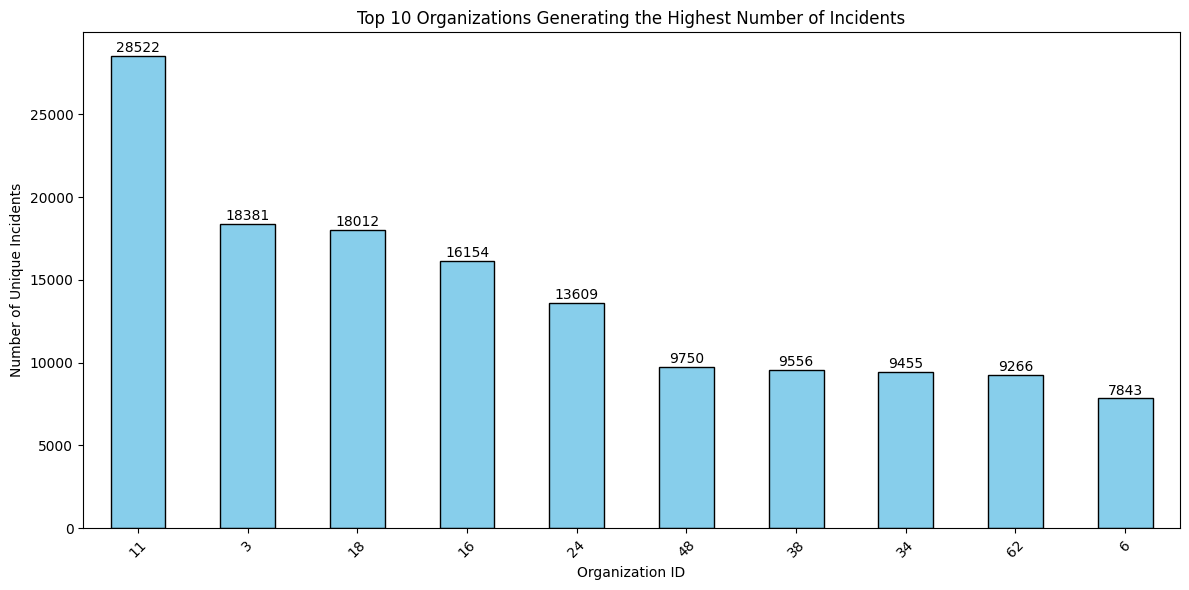

In [36]:
# orgid incident id
incidents_per_org = train_data.groupby('OrgId')['IncidentId'].nunique().sort_values(ascending=False)
top_10_orgs = incidents_per_org.head(10)

plt.figure(figsize=(12, 6))
ax = top_10_orgs.plot(kind='bar', color='skyblue')
top_10_orgs.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Top 10 Organizations Generating the Highest Number of Incidents')
plt.xlabel('Organization ID')
plt.ylabel('Number of Unique Incidents')
plt.xticks(rotation=45)
plt.tight_layout()

for i, v in enumerate(top_10_orgs):
    ax.text(i, v + 50, str(v), ha='center', va='bottom', fontsize=10, color='black')

plt.show()


**Possible Insights:**
* **Incident volume suggests exposure or detection capacity.** Organizations like OrgId 11, with high incident counts, may be more exposed to threats, possibly due to their size, the nature of their business, or the number of systems they manage. Alternatively, they may have better detection capabilities, which results in a larger number of reported incidents.

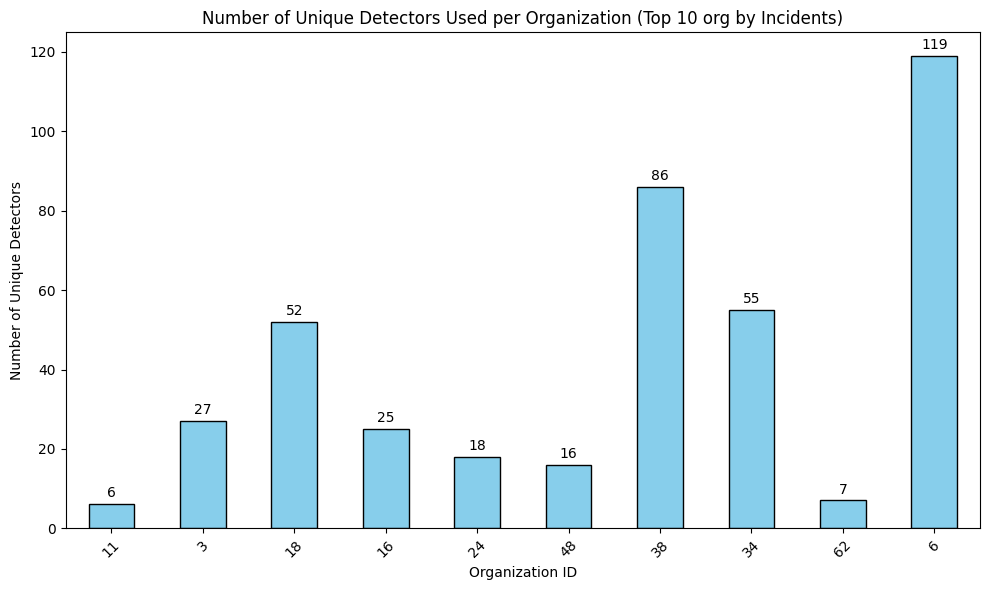

In [37]:
detectors_per_org = train_data.groupby('OrgId')['DetectorId'].nunique()
incidents_per_org = train_data.groupby('OrgId')['IncidentId'].nunique()
top_orgs_by_incidents = incidents_per_org.sort_values(ascending=False).head(10)
detectors_for_top_orgs = detectors_per_org[top_orgs_by_incidents.index]

plt.figure(figsize=(10, 6))
detectors_for_top_orgs.plot(kind='bar', color='skyblue', edgecolor='black')

for i, value in enumerate(detectors_for_top_orgs):
    plt.text(i, value + 1, str(value), ha='center', va='bottom', fontsize=10)

plt.title('Number of Unique Detectors Used per Organization (Top 10 org by Incidents)')
plt.xlabel('Organization ID')
plt.ylabel('Number of Unique Detectors')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


* **OrgId 6** has the **highest number of detectors (119)**, but it ranks 10th in terms of unique incidents (7843 incidents).

* On the other hand, **OrgId 11**, which has the highest number of unique incidents (28,522), **uses only 6 detectors**. This might indicate that even with fewer detectors, this organization has a significant volume of incidents, which could suggest more complex or frequent security events detected by a smaller set of systems.

* **Detector density** does not necessarily correlate directly with the number of incidents. Organizations with fewer detectors (like OrgId 11) might be more focused or efficient at detecting incidents, while organizations with more detectors might have systems in place for a broader range of detection but do not always see more incidents (e.g OrgId 6).

* It might be valuable to **explore the effectiveness of detectors**—whether they are tuned to detect specific types of incidents or have a broader focus, and whether these incidents are being detected with high precision.

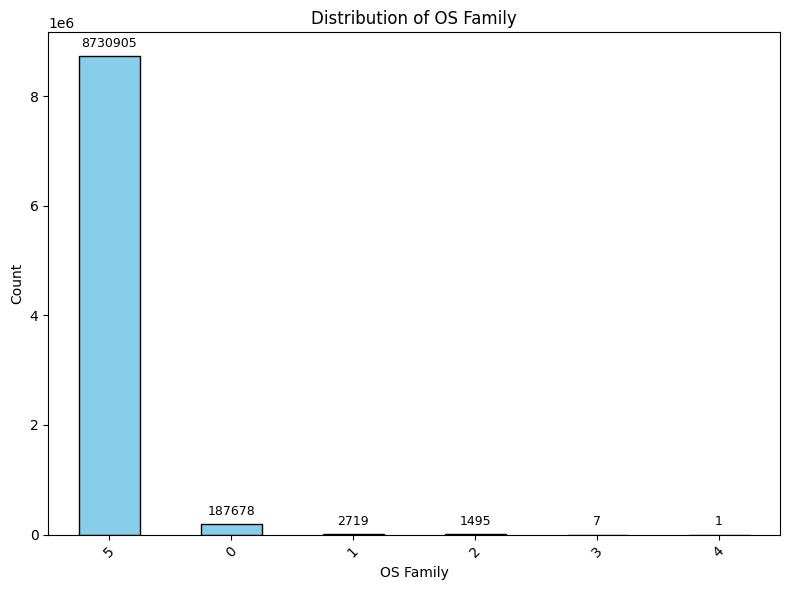

In [38]:
os_family_counts = train_data['OSFamily'].value_counts()

plt.figure(figsize=(8, 6))
os_family_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of OS Family')
plt.xlabel('OS Family')
plt.ylabel('Count')
plt.xticks(rotation=45)

for index, value in enumerate(os_family_counts):
    plt.text(index, value + 0.02 * os_family_counts.max(), 
             str(value), ha='center', fontsize=9, color='black')

plt.tight_layout()
plt.show()


* **OSFamily 5** accounts for the vast majority of the data with 8.7mil occurrences **(99.98%)**.
* The dominance of OSFamily 5 suggests a **lack of diversity** in the operating systems being monitored or involved in incidents. This could indicate that the data is heavily skewed toward environments where a specific OS is standard.
* **Targeted Monitoring or Attack Surface:** The concentration on a single OSFamily may imply that most incidents and threats are targeting this dominant system, potentially because it is widely adopted and presents a larger attack surface.


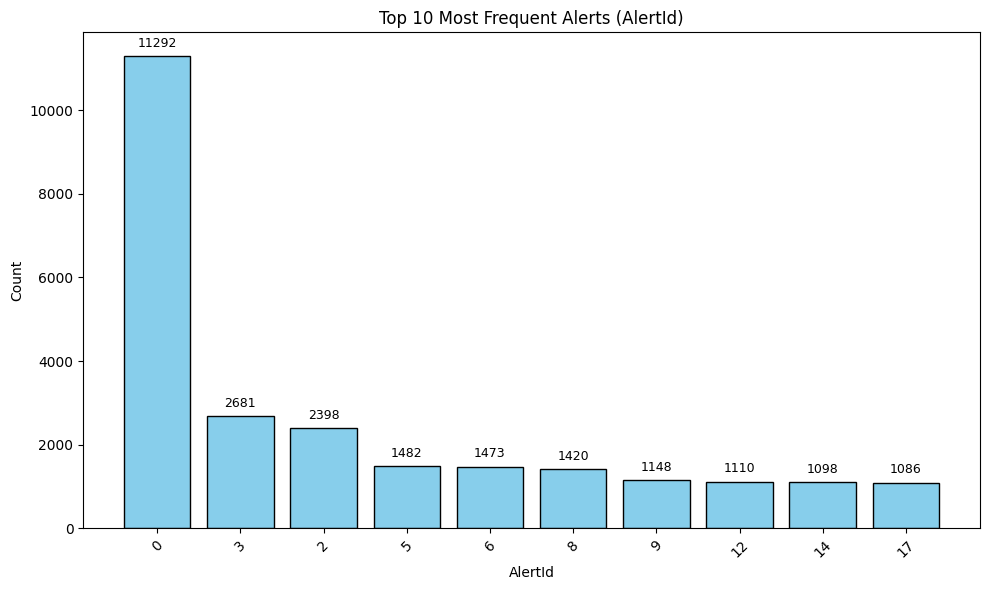

In [39]:
alerts = train_data["AlertId"].value_counts()
top_alerts = alerts.sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
plt.bar(top_alerts.index.astype(str), top_alerts.values, color='skyblue', edgecolor='black')
plt.title('Top 10 Most Frequent Alerts (AlertId)')
plt.xlabel('AlertId')
plt.ylabel('Count')
plt.xticks(rotation=45)

for index, value in enumerate(top_alerts):
    plt.text(index, value + 0.02 * top_alerts.max(), 
             str(value), ha='center', fontsize=9, color='black')
    
plt.tight_layout()
plt.show()

**AlertId Distribution:**

The wide gap between the count for `AlertId` 0 and the others suggests that 0 might correspond to a general or catch-all alert type. This AlertId may require further inspection to understand its significance.

In [40]:
# finding rare alerts: alerts whose alertId frequency is 1

rare_alerts = alerts[alerts == 1]
print("Number of Rare Alerts:", len(rare_alerts))
rare_alerts.head()

Number of Rare Alerts: 27463


AlertId
1646365    1
1659627    1
1673470    1
1691610    1
1695804    1
Name: count, dtype: int64

In [41]:
# calculate percentage of rare alerts
total_alerts = len(alerts)
rare_alert_percentage = (len(rare_alerts) / total_alerts) * 100

print(f"Percentage of Rare Alerts: {rare_alert_percentage:.2f}%")


Percentage of Rare Alerts: 2.20%


In [42]:
# filter rare AlertIds
rare_alert_ids = alerts[alerts == 1].index
rare_alerts_data = train_data[train_data['AlertId'].isin(rare_alert_ids)]

Rare Alerts by Incident Grade:
 IncidentGrade
BenignPositive    19803
FalsePositive      4221
TruePositive       3439
Name: count, dtype: int64


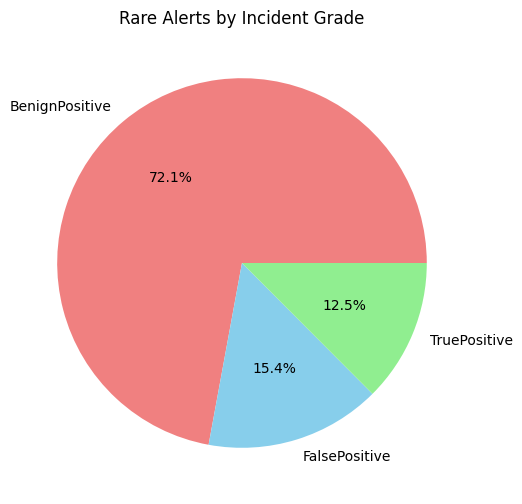

In [43]:
# pie chart for rare alerts by incident grade
incident_grade_distribution = rare_alerts_data['IncidentGrade'].value_counts()

print("Rare Alerts by Incident Grade:\n", incident_grade_distribution)

# Visualize
plt.figure(figsize=(8, 6))
incident_grade_distribution.plot(kind='pie', autopct='%1.1f%%', colors=['lightcoral', 'skyblue', 'lightgreen'])
plt.title('Rare Alerts by Incident Grade')
plt.ylabel('')  # Hide y-axis label
plt.show()


**Rare Alerts Overview:**

* There are **27k rare alerts** where the AlertId occurs only once in the dataset. These represent unique or highly specific alert instances that are not commonly observed.
* Percentage of rare alerts in the dataset: **2.2%**

<br>

**Rare Alerts by Incident Grade:**

* **BenignPositive** incidents account for the majority of rare alerts (72.1% of rare alerts). This suggests that most rare alerts are associated with non-critical or benign events.
* **FalsePositive** incidents contribute 15.4% of rare alerts.
* **TruePositive** incidents account for only 12.5% of rare alerts. This highlights that rare alerts are less frequently linked to confirmed security threats.

<br>

**Insights:**

Since TruePositive rare alerts could represent unique security incidents, they should be analyzed further to determine if they signify emerging threats or vulnerabilities.

## Bivariate analysis

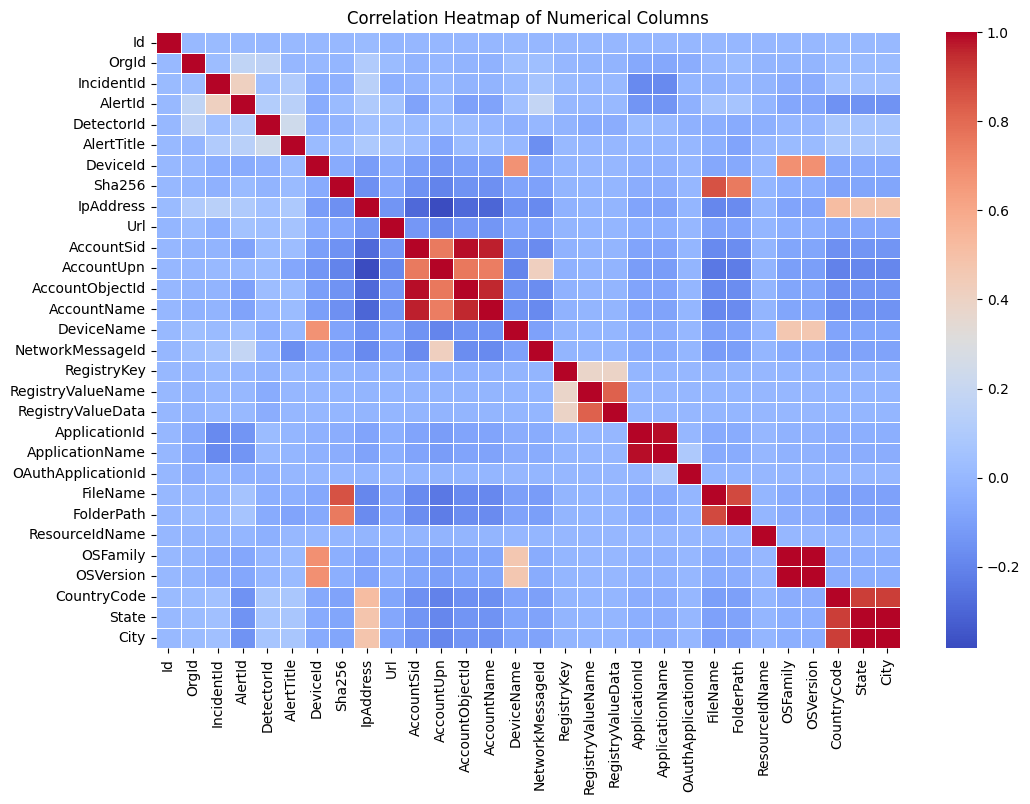

In [44]:
# correlation heatmap for numerical variables
plt.figure(figsize=(12, 8))
corr = train_data[numerical_columns].corr()
sns.heatmap(corr, fmt=".2f", cmap="coolwarm", linewidths=0.5) # kept annotation false for better visuals
plt.title('Correlation Heatmap of Numerical Columns')
plt.show()

In [45]:
# understanding the correlated pairs
corr_pairs = corr.unstack()

sorted_corr_pairs = corr_pairs.abs().sort_values(ascending=False)
high_corr_pairs = sorted_corr_pairs[(sorted_corr_pairs > 0.8) & (sorted_corr_pairs < 1.0)]

filtered_pairs = {}
for (col1, col2), corr in high_corr_pairs.items():
    if (col2, col1) not in filtered_pairs:
        filtered_pairs[(col1, col2)] = corr

for (col1, col2), corr in filtered_pairs.items():
    print(f"{col1:20} {col2:20} {corr:.6f}")


OSFamily             OSVersion            0.999285
State                City                 0.996473
ApplicationId        ApplicationName      0.986349
AccountObjectId      AccountSid           0.984651
AccountName          AccountSid           0.962472
AccountObjectId      AccountName          0.955947
CountryCode          State                0.912175
CountryCode          City                 0.909244
FileName             FolderPath           0.885100
FileName             Sha256               0.862714
RegistryValueName    RegistryValueData    0.823389


**Redundancy in Features**

The extremely high correlations (close to or above 0.99) between certain features, such as:
* `OSFamily` and `OSVersion` (0.999)
* `ApplicationId` and `ApplicationName` (0.986)
* `AccountObjectId`, `AccountSid`, and `AccountName` (0.985, 0.962, 0.956), indicate redundancy.

This means that these features are essentially conveying the same information and can potentially be reduced or combined without losing critical insights.

<br>

* Retaining all highly correlated features could lead to multicollinearity issues in predictive modeling.
* Simplifying the dataset by removing redundant features will reduce complexity without compromising predictive performance.

In [46]:
contingency_table = pd.crosstab(train_data['IncidentGrade'], train_data['Category'])
contingency_table

Category,Collection,CommandAndControl,CredentialAccess,CredentialStealing,DefenseEvasion,Discovery,Execution,Exfiltration,Exploit,Impact,InitialAccess,LateralMovement,Malware,Persistence,PrivilegeEscalation,Ransomware,SuspiciousActivity,UnwantedSoftware,Weaponization,WebExploit
IncidentGrade,,,,,,,,,,,,,,,,,,,,
BenignPositive,5517,563515,118636,0,21471,71300,134072,1080772,2569,336976,782793,26774,91771,55948,4147,12501,505778,13230,0,30
FalsePositive,7055,145506,71133,377,14037,34210,87848,368852,597,171348,880887,8683,17120,12893,417,302,131209,2403,0,2
TruePositive,1874,116559,107803,9,10716,22408,44813,101077,1417,242523,2088358,4646,31930,3603,101,4574,355331,2372,6,6


In [47]:
# pairwise Chi-Square test for all categorical columns
for col1 in categorical_columns:
    for col2 in categorical_columns:
        if col1 != col2:
            contingency_table = pd.crosstab(train_data[col1], train_data[col2])
            chi2, p, dof, expected = chi2_contingency(contingency_table)
            print(f"Chi2 Test Between {col1} and {col2}")
            print("Chi2 Statistic:", chi2, "| p-value:", p, "| Degrees of Freedom:", dof)
            print("-" * 40)


Chi2 Test Between IncidentGrade and Category
Chi2 Statistic: 1959409.2817164126 | p-value: 0.0 | Degrees of Freedom: 38
----------------------------------------
Chi2 Test Between IncidentGrade and EntityType
Chi2 Statistic: 1778111.989285393 | p-value: 0.0 | Degrees of Freedom: 64
----------------------------------------
Chi2 Test Between Category and IncidentGrade
Chi2 Statistic: 1959409.2817164126 | p-value: 0.0 | Degrees of Freedom: 38
----------------------------------------
Chi2 Test Between Category and EntityType
Chi2 Statistic: 11358824.137560664 | p-value: 0.0 | Degrees of Freedom: 608
----------------------------------------
Chi2 Test Between EntityType and IncidentGrade
Chi2 Statistic: 1778111.989285393 | p-value: 0.0 | Degrees of Freedom: 64
----------------------------------------
Chi2 Test Between EntityType and Category
Chi2 Statistic: 11358824.137560666 | p-value: 0.0 | Degrees of Freedom: 608
----------------------------------------


**Interpretation of the Chi-Square Tests**

Chi-Square tests provide insights into the relationships between categorical variables.
(null hypothesis rejected if p value<=0.05)

* **Statistical Significance:** All relationships analyzed are statistically significant (p-value = 0.0), meaning these variables are not independent of each other.

<br>

* **Category ↔ IncidentGrade:** Helps predict the grade of an incident based on its category.

* **EntityType ↔ IncidentGrade:** Highlights the role of evidence types in severity determination.

* **EntityType ↔ Category:** Facilitates understanding of which types of evidence dominate in specific categories.


These strong associations suggest that `Category` and `EntityType` could be critical features in predictive modeling for incident severity or classification.

## Time series analysis

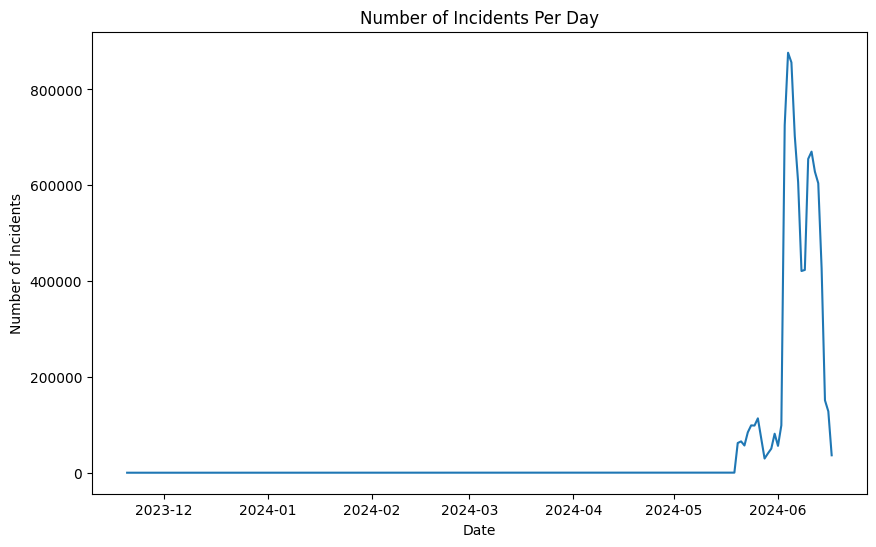

In [48]:
train_data['day'] = train_data['Timestamp'].dt.date
incidents_per_day = train_data.groupby('day').size()

plt.figure(figsize=(10, 6))
incidents_per_day.plot()
plt.title('Number of Incidents Per Day')
plt.xlabel('Date')
plt.ylabel('Number of Incidents')
plt.show()

* The observed spike in incidents after May 2024, peaking in mid-June and decreasing thereafter, may reflect either external events, changes in incident detection, or the resolution of specific security issues. 

In [49]:
print(f'timestamp unique vals: {train_data["Timestamp"].nunique()}')

timestamp unique vals: 755654


In [50]:
min_timestamp = train_data['Timestamp'].min()
max_timestamp = train_data['Timestamp'].max()

print(f"minimum timestamp: {min_timestamp}")
print(f"maximum timestamp: {max_timestamp}")

minimum timestamp: 2023-11-20 16:32:22+00:00
maximum timestamp: 2024-06-17 14:45:38+00:00


In [51]:
# extracting year and month from the timestamp
train_data['YearMonth'] = train_data['Timestamp'].dt.to_period('M')

# counting number of entries per month
monthly_counts = train_data['YearMonth'].value_counts().sort_index()
print(monthly_counts)

YearMonth
2023-11         11
2023-12        168
2024-01        310
2024-02        297
2024-03        235
2024-04        287
2024-05     853020
2024-06    8068477
Freq: M, Name: count, dtype: int64


<ipython-input-51-86bdda8554fc>:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  train_data['YearMonth'] = train_data['Timestamp'].dt.to_period('M')


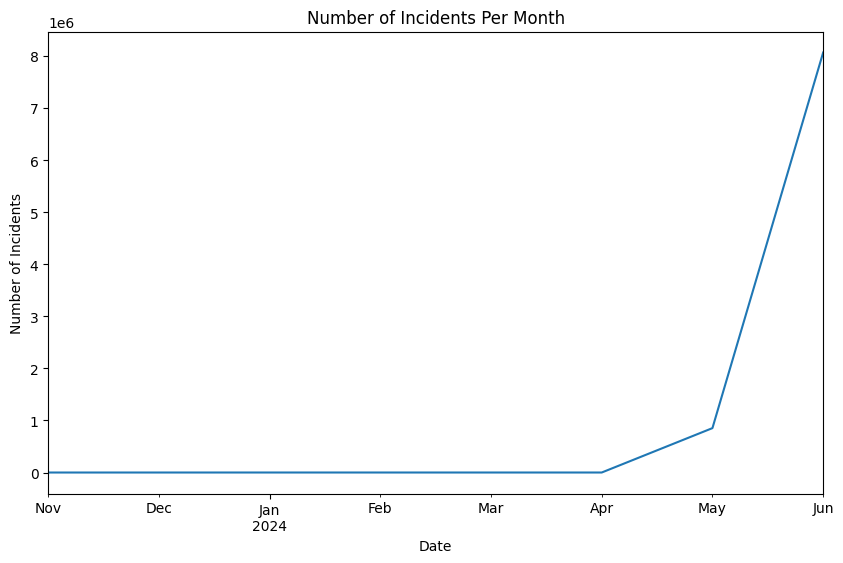

In [52]:
incidents_per_month = train_data.groupby('YearMonth').size()

plt.figure(figsize=(10, 6))
incidents_per_month.plot()
plt.title('Number of Incidents Per Month')
plt.xlabel('Date')
plt.ylabel('Number of Incidents')
plt.show()

The trend observed, a slight increase in the number of incidents from April to May followed by a sharp spike in June, suggests several potential insights and avenues for further investigation.

* Increased Threat Activity
* Improved Detection
* Increased Activity or Changes in the Business Environment
* Security Policy Changes
* Cyberattack Campaigns

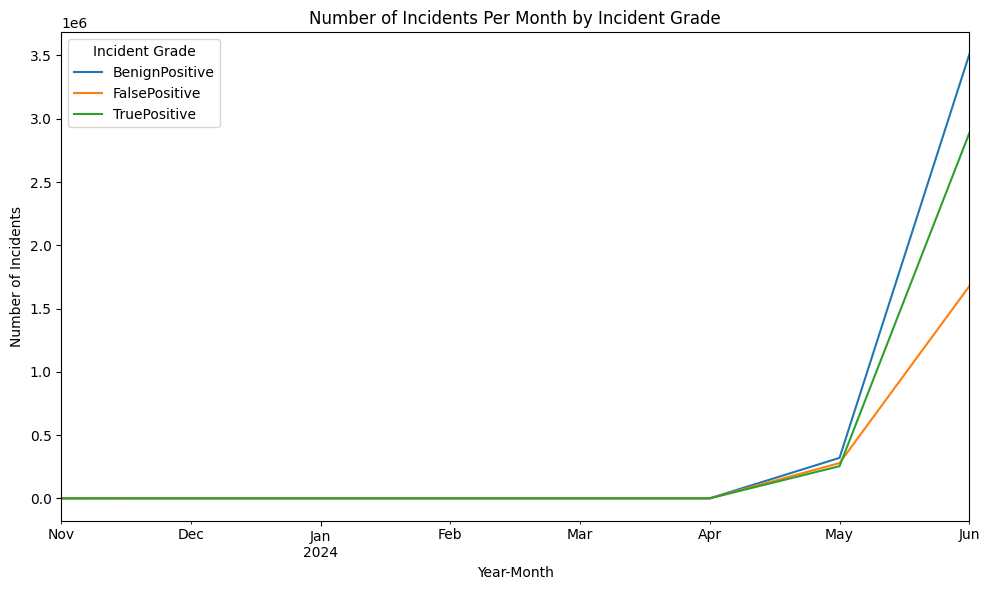

In [53]:
incidents_per_month_grade = train_data.groupby(['YearMonth', 'IncidentGrade']).size().unstack(fill_value=0)

incidents_per_month_grade.plot(figsize=(10, 6))

plt.title('Number of Incidents Per Month by Incident Grade')
plt.xlabel('Year-Month')
plt.ylabel('Number of Incidents')
plt.legend(title='Incident Grade')
plt.tight_layout()
plt.show()


number of incidents per month by incident grade.

all 3 incident grades follow similar trend with a slight increase from april to may and then spike in june where benign positive has the highest spike, followed by true positive and a slight increase in false positives from may to june

**BenignPositive:** This incident grade typically refers to incidents that were initially flagged but are later identified as not harmful or low-risk. The sharp spike in June for this grade suggests that there was either:
* **Increased Alert Sensitivity:** A surge in benign positive incidents could indicate that security systems or tools became more sensitive, leading to an increase in non-malicious alerts being generated.
* **More False Alarms:** A large number of incidents marked as BenignPositive could also point to an issue with detection algorithms or a misclassification of certain benign activities as threats.

<br>

**TruePositive:** These incidents are real threats that were accurately identified. The increase in True Positive incidents in June, though not as large as BenignPositive, still shows that actual security incidents or breaches were more prevalent during that period.
This could be due to **increased Cybersecurity Threats**

<br>

**FalsePositive:** False positives are flagged incidents that are later determined to be benign or not a threat. The slight increase in false positives from May to June may indicate:
* **Changes in Detection Mechanisms**
* **A Refinement Process** 

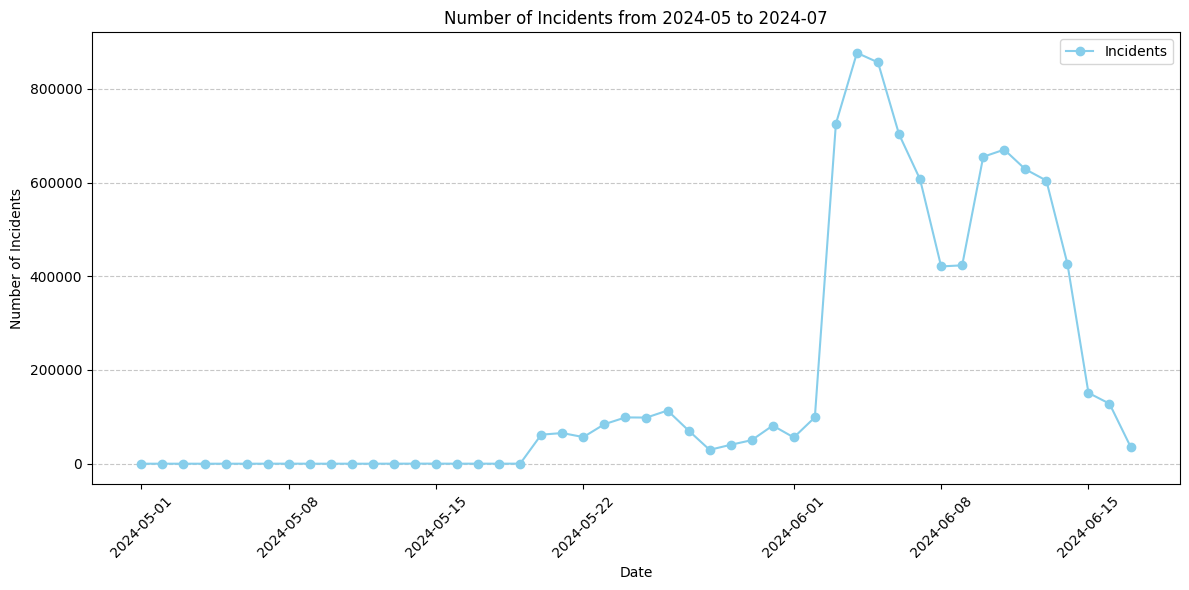

In [54]:
# filter data between the specified dates (may 2024 to july 2024) for a zoomed in look
start_date = '2024-05'
end_date = '2024-07'
filtered_data = train_data[(train_data['YearMonth'] >= start_date) & (train_data['YearMonth'] <= end_date)]

daily_counts = filtered_data.groupby(filtered_data['Timestamp'].dt.date).size()

plt.figure(figsize=(12, 6))
plt.plot(daily_counts.index, daily_counts.values, marker='o', linestyle='-', color='skyblue', label='Incidents')

plt.title(f'Number of Incidents from {start_date} to {end_date}')
plt.xlabel('Date')
plt.ylabel('Number of Incidents')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

plt.tight_layout()
plt.show()

**Number of incidents between may 2024 to july 2024 for a more granular view**

**Outlier Analysis**

# Data Transformation

In [55]:
train_data.shape

(8922805, 37)

In [56]:
# train_data.drop(['day', 'YearMonth'], axis=1, inplace=True)
# train_data_cols = train_data.columns
# test_data = test_data[train_data_cols]

In [57]:
# X_train = train_data.drop(columns=['IncidentGrade'])
# y_train = train_data['IncidentGrade']

# X_test = test_data.drop(columns=['IncidentGrade'])
# y_test = test_data['IncidentGrade']

In [58]:
# print(X_train.shape)
# print(X_test.shape)

In [59]:
# # Separate numerical and categorical columns
# numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
# categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()

In [60]:
# print(numerical_cols)
# print(categorical_cols)

In [61]:
# # encoding categorical cols
# for col in categorical_cols:
#     encoder = LabelEncoder()
#     X_train[col] = encoder.fit_transform(X_train[col].astype(str))
#     X_test[col] = encoder.transform(X_test[col].astype(str))

In [62]:
# # encoding label
# encoder = LabelEncoder()
# y_train = encoder.fit_transform(y_train)
# y_test = encoder.transform(y_test)

# Insights from the dataset

## Additional Analysis

**How different types of evidence (IP addresses, email addresses, etc) are related to the classification of incidents into different triage grades (IncidentGrade)**

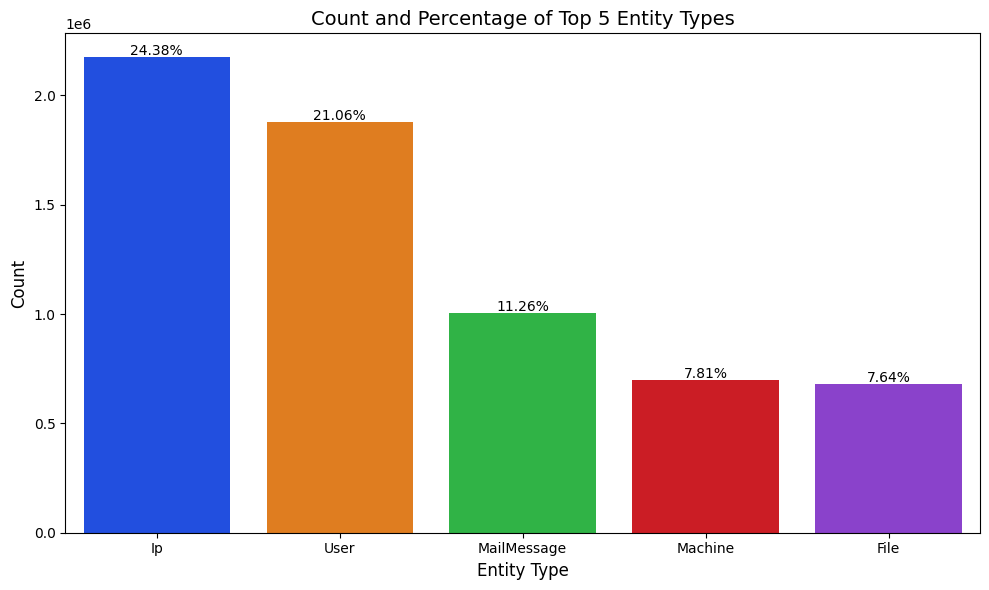

In [63]:
# top 5 entity types by count
top_entity_types = train_data['EntityType'].value_counts().head(5).index

filtered_data = train_data[train_data['EntityType'].isin(top_entity_types)]

entity_type_counts = filtered_data['EntityType'].value_counts()
total_count = train_data.shape[0]   # length of train data
entity_type_percentages = (entity_type_counts / total_count) * 100

plt.figure(figsize=(10, 6))
ax = sns.countplot(data=filtered_data, x='EntityType', order=top_entity_types, palette='bright')

for p, percentage in zip(ax.patches, entity_type_percentages):
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(f'{percentage:.2f}%', (x, y + 0.001 * total_count), ha='center', fontsize=10, color='black')

plt.title("Count and Percentage of Top 5 Entity Types", fontsize=14)
plt.xlabel("Entity Type", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.tight_layout()
plt.show()

**IP (24.38%):**
* The highest proportion of the incidents are associated with the `Ip` entity type. 
* This indicates that IP addresses are one of the most common types of evidence in incidents. 
* This high percentage suggests that many incidents involve network-based attacks or are related to network communication.

<br>

**User (21.06%):**
* The second-highest proportion comes from the `User` entity type.
* This suggests that user accounts (including user-specific metadata like account names or credentials) are a significant part of the incidents.
* User data plays a key role in identifying threats or compromised accounts.

<br>

**MailMessage (11.26%):**
* `Mail messages` make up about 11% of the incidents.
* This indicates that email-based threats (such as phishing emails, malware attachments, or suspicious communications) are common.
* Email communication could be one of the primary ways of spreading malware or conducting social engineering attacks, which is why it appears prominently in this dataset.


**The top 5 categories of Entity Type cover approx 72% of the entire dataset** 

In [64]:
print(f'total percentage of data having top 5 entity types (evidence): {entity_type_percentages.sum():.2f}%')

total percentage of data having top 5 entity types (evidence): 72.15%


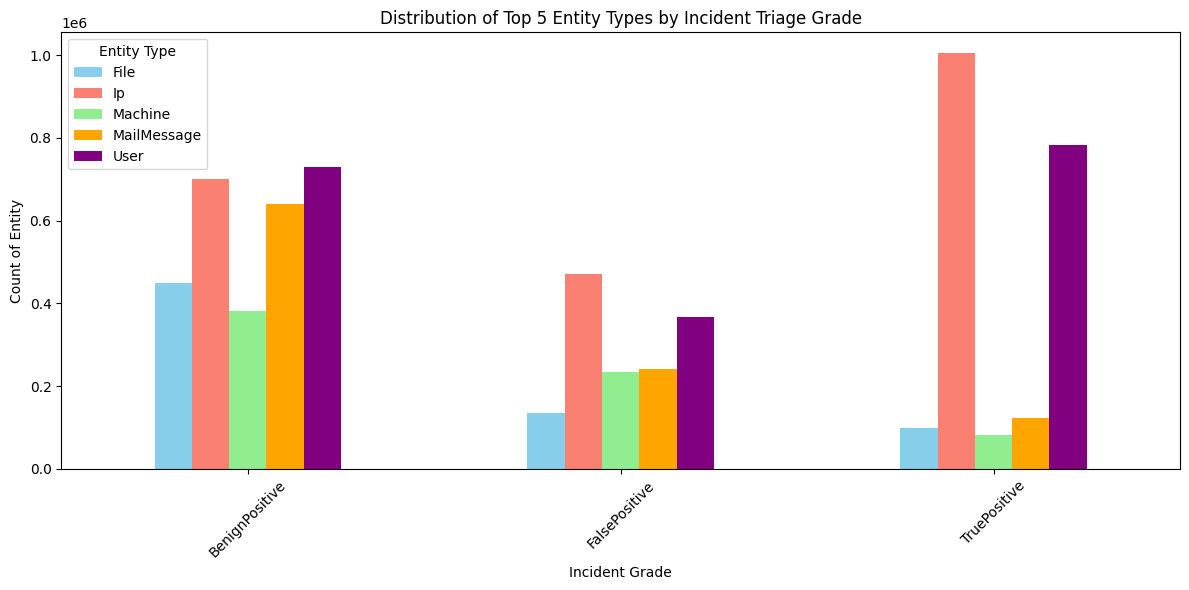

In [65]:
# top 5 entity types by Incident Grades
filtered_data = train_data[train_data['EntityType'].isin(top_entity_types)]

# group by, then unstack for visualization
evidence_by_grade_top5 = filtered_data.groupby(['IncidentGrade', 'EntityType']).size().unstack(fill_value=0)

evidence_by_grade_top5.plot(kind='bar', figsize=(12, 6), color=['skyblue', 'salmon', 'lightgreen', 'orange', 'purple'])
plt.title("Distribution of Top 5 Entity Types by Incident Triage Grade")
plt.xlabel("Incident Grade")
plt.ylabel("Count of Entity")
plt.xticks(rotation=45)
plt.legend(title="Entity Type")
plt.tight_layout()
plt.show()

* **`User` and `Ip` are dominant entity types for all three insident grades**
* **IP and user evidence types are the strongest contributors to incidents classified as `true positives`.**
* **This indicates that network-level and user-level monitoring are critical for detecting genuine threats.**

**trends of attack types (category) over time:**

In [66]:
category_trends = train_data.groupby([train_data['Timestamp'].dt.to_period('M'), 'Category']).size().unstack(fill_value=0)
print('\ncategory trends over time (numerical data):')
category_trends.head(10)

<ipython-input-66-9f012af2c0b6>:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  category_trends = train_data.groupby([train_data['Timestamp'].dt.to_period('M'), 'Category']).size().unstack(fill_value=0)



category trends over time (numerical data):


Category,Collection,CommandAndControl,CredentialAccess,CredentialStealing,DefenseEvasion,Discovery,Execution,Exfiltration,Exploit,Impact,InitialAccess,LateralMovement,Malware,Persistence,PrivilegeEscalation,Ransomware,SuspiciousActivity,UnwantedSoftware,Weaponization,WebExploit
Timestamp,,,,,,,,,,,,,,,,,,,,
2023-11,0,0,0,0,0,0,0,0,0,0,11,0,0,0,0,0,0,0,0,0
2023-12,0,0,0,0,0,3,0,4,0,0,161,0,0,0,0,0,0,0,0,0
2024-01,0,0,0,0,0,40,0,0,0,0,270,0,0,0,0,0,0,0,0,0
2024-02,0,0,0,0,0,34,0,0,0,0,263,0,0,0,0,0,0,0,0,0
2024-03,0,0,0,0,0,48,0,0,0,0,187,0,0,0,0,0,0,0,0,0
2024-04,0,0,0,0,0,96,0,0,0,0,191,0,0,0,0,0,0,0,0,0
2024-05,166,66081,10487,0,137,10866,4650,9162,0,581881,156246,7294,80,2470,0,0,3396,104,0,0
2024-06,14280,759499,287085,386,46087,116831,262083,1541535,4583,168966,3594709,32809,140741,69974,4665,17377,988922,17901,6,38


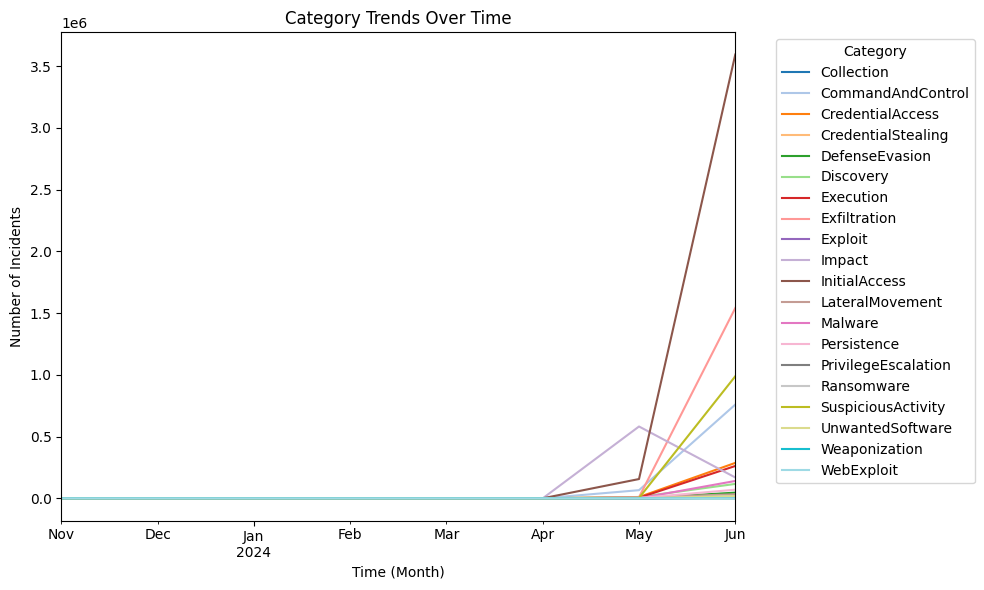

In [67]:
# to generate a palette with 20 distinct colors for better visibility
category_palette = sns.color_palette("tab20", n_colors=len(category_trends.columns))
category_trends.plot(kind='line', figsize=(10,6), color=category_palette)

plt.title("Category Trends Over Time")
plt.xlabel("Time (Month)")
plt.ylabel("Number of Incidents")
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

* **`Impact` category had spike in `may month` and then showed a decline**
* **`Initial Access` category showed a slight rise from april to may and then spiked in june**
* **Top categories in june 2024 were: `Initial Access`, `Exfilteration`, `Suspicious activity`, `command and control` and `credential access`**

**relationship between EntityType and EvidenceRole (role of this evidence in the alert)**

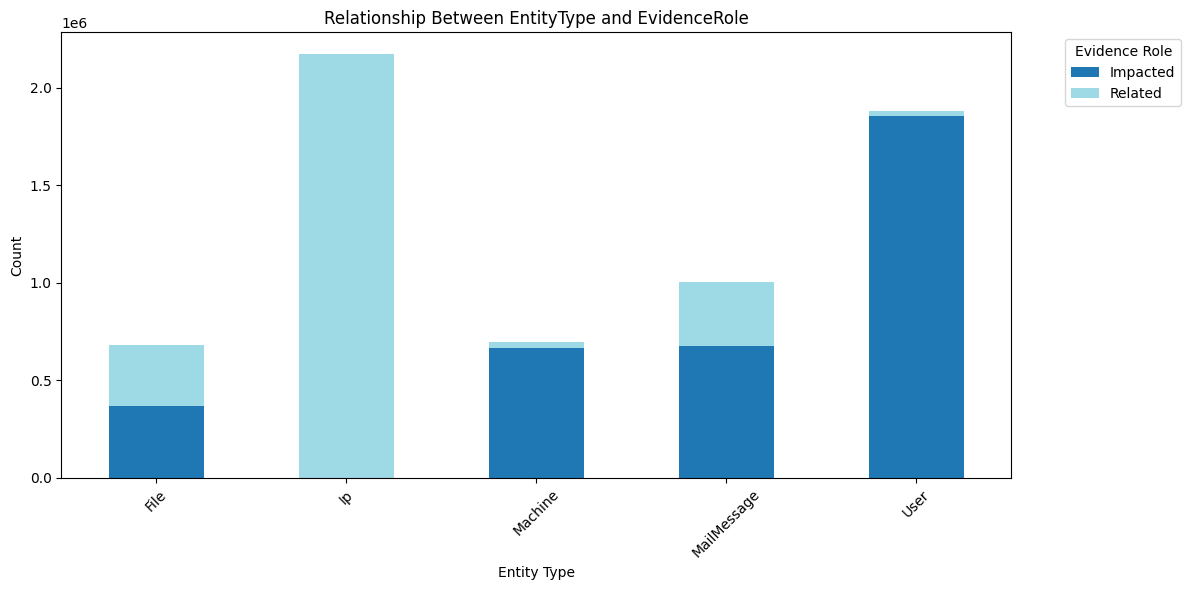

In [68]:
entity_role_crosstab = pd.crosstab(filtered_data['EntityType'], train_data['EvidenceRole'])

# stacked bar plot
entity_role_crosstab.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='tab20')
plt.title('Relationship Between EntityType and EvidenceRole')
plt.xlabel('Entity Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Evidence Role', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

* **all incidents with EntityType = `IP` were related rather than directly impacted**
* **98% of incidents involving EntityType = `User` were impacted**
    * The fact that 98% of incidents involving User-related evidence were classified as impacted suggests that incidents associated with users are much more likely to result in actual damage or security breaches
* **5% of incidents involving EntityType = `Machine` were impacted**

In [69]:
entity_role_crosstab_percent_rows = entity_role_crosstab.div(entity_role_crosstab.sum(axis=1), axis=0) * 100
print(entity_role_crosstab_percent_rows)


EvidenceRole   Impacted     Related
EntityType                         
File          54.079806   45.920194
Ip             0.000000  100.000000
Machine       95.289976    4.710024
MailMessage   67.455995   32.544005
User          98.561176    1.438824


In [70]:
pd.crosstab(train_data['EntityType'], train_data['EvidenceRole'])

EvidenceRole,Impacted,Related
EntityType,,
ActiveDirectoryDomain,0,11
AmazonResource,6,0
AzureResource,8100,0
Blob,0,263
BlobContainer,0,306
CloudApplication,209785,7012
CloudLogonRequest,0,632503
CloudLogonSession,0,210556
Container,0,2


## Insights on Predicting Security Incidents Effectively

#### Key Findings from the Exploratory Data Analysis (EDA)

The exploratory data analysis revealed several patterns and trends within the dataset that could significantly inform the prediction of security incidents:

<br>

---

#### 1. Dataset Overview

- The dataset contains hierarchical information across three levels:
    - **Evidence:** Smallest unit of analysis (e.g, IP, Email, User).
    - **Alerts:** Consolidated multiple pieces of evidence indicating potential threats.
    - **Incidents:** Cohesive grouping of one or more alerts that signify security events.
- **Incident Grade Distribution:**
    - The `IncidentGrade` variable consists of three categories: **TruePositive**, **FalsePositive**, and **BenignPositive**.
    - `BenignPositive`: 42.8% of data, `TruePositive`: 35% of data, `FalsePositive`: 21.9% of data.
    - There is a clear **class imbalance**, with **BenignPositive** incidents representing almost double the entries compared to **FalsePositive** incidents.
    - This imbalance can lead to bias in model predictions, making it less effective at detecting minority classes (e.g., FalsePositive).

<br>

- **Categories of Alerts:**
    - The most common alert categories are:
      - **InitialAccess** (42%)
      - **Exfiltration** (17%)
      - **SuspiciousActivity** (11%)
    - A significant portion of incidents is concentrated in these top categories, while others contribute to a smaller percentage of the data.

<br>

- **Entity Types:**
    - The dataset includes **33 different types of entities** involved in the incidents.
    - The top 3 entity types are:
      - **IP** (24.38%)
      - **User** (21.06%)
      - **MailMessage** (11.26%)
    - The remaining entity types make up less than 10% each.

<br>

- **Global Scope:**
    - The data spans **5.3k unique organizations**, with incidents recorded across **236 countries**.
    - It involves **7.8k different detectors**, pointing to a wide range of detection systems used by various organizations.
    - The incidents are observed across **6 different operating system families**, showing the diversity of environments affected by security threats.

<br>

---

#### 2. Incident and Alert Characteristics

<br>

- **Incident Volume:**
    - The volume of incidents suggests a potential relationship between **exposure to threats** and the **detection capacity** of an organization.
      - For example, **OrgId 11** has the highest number of unique incidents (28,522) but only 6 detectors, indicating that fewer but potentially more complex incidents are being detected.
      - Conversely, **OrgId 6** uses 119 detectors but ranks 10th in incident volume, suggesting a broader but less concentrated threat detection approach.

<br>

- **Operating System and Targeted Monitoring:**
    - **OSFamily 5** dominates the dataset, accounting for **99.98%** of incidents. This indicates a lack of diversity in the operating systems being monitored or involved in incidents, possibly pointing to a concentration on a single OS due to its widespread usage or higher attack surface.

<br>

- **Rare Alerts:**
    - About **2.2%** of alerts are rare (occur only once), and a large portion of these rare alerts (**72.1%**) are classified as **BenignPositive**. This suggests that most rare alerts correspond to benign or low-risk events.
    - **TruePositive** rare alerts account for only **12.5%**, highlighting that rare alerts are less likely to indicate critical security breaches but may warrant further investigation, especially if they are emerging threats.

<br>

---

#### 3. Bivariate Analysis Insights

<br>

- **Feature Redundancy:**
    - Several features exhibit high correlation (e.g., `OSFamily` with `OSVersion` at 0.999), indicating redundancy in the dataset.
    - Redundant features should be eliminated or combined to prevent multicollinearity in predictive models, thus improving model interpretability and performance.

<br>

- **Chi-Square Test Results:**
    - Significant relationships were found between:
      - `IncidentGrade` and `Category`
      - `IncidentGrade` and `EntityType`
      - `EntityType` and `Category`
    - These associations suggest that **Category** and **EntityType** are key factors in predicting the severity of an incident, making them valuable features for predictive modeling.

<br>

---

#### 4. Temporal Trends

<br>

- **Incident Trends (May to June 2024):**
    - A notable spike in incidents was observed in **June 2024**, particularly for **BenignPositive** incidents. This could indicate:
      - **Increased alert sensitivity**, leading to more benign alerts being flagged.
      - Potential **false alarms** or misclassification of certain activities.
    - **TruePositive** incidents also saw an increase in June, suggesting a rise in actual security breaches or threats.

<br>

- **Category Trends:**
    - The **`InitialAccess`** category exhibited a rise from **April to May**, followed by a sharp spike in **June**, indicating heightened activity in cyberattacks targeting initial access points.
    - Other significant categories such as **Exfiltration**, **SuspiciousActivity**, and **Impact** also saw increased activity, with **Exfiltration** and **SuspiciousActivity** making up a larger portion of incidents in June 2024.

<br>

---

#### 5. Entity Type Insights

<br>

- **IP and User:**
    - **IP** and **User** are the dominant entity types across all incident grades, particularly in **TruePositive** incidents. This highlights the importance of monitoring both **network-level** (IP) and **user-level** (User) evidence to detect genuine security threats.

<br>

- **MailMessage:**
    - **Email-based threats** (e.g., phishing, malware) are significant, with **MailMessage** being the third most common entity type (**11.26%**). This suggests that email communication remains a critical factor for malware distribution or social engineering attacks.

<br>

- **Impact of User and IP:**
    - **98% of incidents involving User-related evidence** were classified as **Impacted**, suggesting that user-related incidents are more likely to result in security breaches or damage.
    - Conversely, incidents involving **IP** evidence were typically classified as related rather than directly impacted, indicating that many network-level alerts may not result in direct harm but could still provide valuable indicators of potential threats.

<br>

---

#### 6. Recommendations for Future Analysis and Modeling

<br>

- **Class Imbalance:**
    - The **class imbalance** in incident grades suggests the need for techniques like **oversampling** (SMOTE), **undersampling**, or **class weighting** to avoid model bias.
    - Use stratified sampling for handling imbalanced classes during training.

<br>

- **Feature Engineering:**
    - The **extremely high correlations** (close to or above 0.99) between certain features indicate redundancy.
    - **Redundant features** should be **eliminated or combined** to prevent multicollinearity in predictive models.
    - Simplify feature space using techniques like **PCA** or **feature selection** to improve model **performance and interpretability**.

<br>

- **Modeling Approaches:**
    - Given the categorical nature of the dataset, **tree-based models** such as **Random Forests** or **XGBoost** should be considered, as they are capable of handling imbalanced datasets and categorical features effectively.

---


### Notes

**multicolinearity**
It is bad to have high two or more highly correlated independent variables in a predictive model. They **explain the same variation** and also influence each other as well. You will never get to know how much variation each of the individual variable is contributing to the overall variation.

**missing value treatment**: Consider two categorical variables (IDVs) : X1 and X2 and they are trying to predict Y. X1 and X2 are highly correlated and so we have to pick one of them. Variable X1 is making more business sense but data is populated only for 90% of the records. So missing values of X1 can be easily imputed using X2 as they are correlated.

**p-value:** It is the probability of getting an extreme value when Null hypothesis is true. 
Small P-Value (≤0.05) suggests strong evidence against the null hypothesis.

**Mitre ATT&CK**: MITRE ATT&CK is a free, publicly available knowledge base that documents cyber attacker tactics and techniques. domains of mitre attack techniques: Enterprise, Mobile and ICS (industrial control systems)

**Tactic**: The **why**: High-level objective. eg: Initial Access, Persistence, etc.

**Technique**: The **how**: Specific method or action. eg: Phishing, Keylogging, Exfiltration Over Web Service, et

**InitialAccess**: refers to the **tactic** used by attackers to **gain** the **first entry point** into a target system or network, essentially establishing a foothold before further exploitation within the environment. This is considered a **crucial phase** in an attack as it sets the stage for further malicious activities within the compromised system. 